In [1]:
'''

The purpose/objective of this notebook is :


The following notebooks should be run before this notebook or are used to generate input files for the notebook:




# save all the global variable in a dataclass G
@dataclass
class G():
    Class to hold global variables
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files

    #output files

    #variables to change
    save_output=True
    save_output_figures=False


'''

"\n\nThe purpose/objective of this notebook is :\n\n\nThe following notebooks should be run before this notebook or are used to generate input files for the notebook:\n\n\n\n\n# save all the global variable in a dataclass G\n@dataclass\nclass G():\n    Class to hold global variables\n    write_dir='/home/ubuntu/write/'\n    repo_parent_dir='../../'\n    WRITE_CACHE=False\n    #input files\n\n    #output files\n\n    #variables to change\n    save_output=True\n    save_output_figures=False\n\n\n"

In [2]:
%%bash
cd
pwd
cd /home/ubuntu/data/ARCHS4/
ls

/home/ubuntu
checksum
human_gene_v2.2.h5
human_gene_v2.3.h5
human_gene_v2.4.h5
human_transcript_v2.2.h5
mouse_gene_v2.2.h5
mouse_gene_v2.3.h5
mouse_gene_v2.4.h5
mouse_transcript_v2.2.h5


## Global variables

In [3]:
# save all the global variable in a dataclass G
from dataclasses import dataclass
@dataclass
class G():
    '''Class to hold global variables'''
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files
    #ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/archs4_gene_human_v2.1.2.h5'
    ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/human_gene_v2.2.h5'

    #output files
    filtered_meta_data_csv_file='meta_samples_dermatitis.csv'

    #variables to change
    save_output=True
    save_output_figures=False

    

# libraries standard paths and settings

In [4]:
#write_dir='/home/ubuntu/write/'
#repo_parent_dir='../../'

import sys
if G.repo_parent_dir not in sys.path:
    sys.path.append(G.repo_parent_dir)

import adata_and_scanpy_tools as asctl

import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#WRITE_CACHE=False # use false if  in github repo or cache files not in git ignore

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [6]:
### import extra packages
import h5py
import scipy as sp
#import h5sparse

# Analysis starts here:

### filter  and other functions

In [7]:
def load_ARCHS4_H5_to_df( ARCHS4_H5_file):
    '''load a ARCHS4_H5 file to a pandas dataframe'''
    ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    meta_samples = ARCHS4_H5['meta/samples']
    df = pd.DataFrame()
    for name, item in meta_samples.items():
        if isinstance(item, h5py.Dataset):
            values = item[:]
            values = [val.decode('utf-8') if isinstance(val, bytes) else val for val in values]
            df[name]= values
            df[name]= df[name].astype(item.dtype) 
    # now re order the columns
    new_column_order=['geo_accession', 'title', 'type','characteristics_ch1','source_name_ch1', 'sample','series_id','molecule_ch1', 'extract_protocol_ch1', 'readsaligned', #'readstotal',
                       'library_selection', 'library_source', 'library_strategy',  'singlecellprobability', 'submission_date', 'data_processing',
                      'status', 'last_update_date',  'channel_count',  'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 
                        'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute']

    df = df[new_column_order].copy()
    return df


def basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=.5,min_readsaligned=1,max_readsaligned=1e15):
    '''filter the df to only include bulk RNAseq
    min_singlecellprobability: float, default .5
    min_readsaligned=1: int, default 1
    ,max_readsaligned=1e15: int, default  1e15
    '''
    df=df.loc[(df['library_selection'].isin(['cDNA']))
              &(df['molecule_ch1'].isin(['total RNA','polyA RNA']))
              &(df['singlecellprobability']<min_singlecellprobability)
              &(df['readsaligned']>=min_readsaligned)
              &(df['readsaligned']<=max_readsaligned)
              ,:].copy()
    print('filtering for library_selection = cDNA')
    print('filtering for molecule_ch1 =total RNA or polyA RNA')
    print(f'filtering for singlecellprobability <{min_singlecellprobability}')
    return df

def filter_df(df, search_strings, include=True,ignore_columns=None,include_only_columns=None):
    '''
    filter the ARCHS4 meta data  dataframe to only include rows where an arbitrary list of string is present
    df: dataframe
    search_strings: list of strings
    include: bool, default True
    ignore_columns: list of columns to ignore
    include_only_columns: list of columns to include
    '''
    import re
    import pandas as pd

    # Apply element-wise bolean mask using applymap-like behavior with apply function to apply to each column
    ## function is case insensitive
    bolean_table = df.apply(
        lambda col: col.apply(
            lambda x: x if pd.isnull(x) 
            else any(search_string.lower() in x.lower()for search_string in search_strings) if isinstance(x, str) else False
        )
    )
    # now remove the columns that are in ignore_columns from the bolean_table 'result' df
    if ignore_columns:
       bolean_table=bolean_table.drop(columns=ignore_columns)
    if include_only_columns:
        bolean_table=bolean_table[include_only_columns]
    # now colapse the bolean_table to a single column .any(axis=1) to filter the rows and keep only the rows that have at least one True
    if include:
        df=df.loc[bolean_table.any(axis=1),:].copy()
        print(f'filtering to include {search_strings}')
    else:
        df=df.loc[~bolean_table.any(axis=1),:].copy()
        print(f'filtering to exclude {search_strings}')
    return df

def split_characteristics_ch1(df):
    ### this funciton split the characteristics_ch1 column into multiple columns
    return df

def return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=False):
    '''return adata from a h5 file and a filtered metadata df
    ARCHS4_H5: h5 file
    filtered_metadata_df: dataframe with the same index as the ARCHS4_H5
    return_df_only=False
    '''
    import anndata
    import pandas as pd
    #make var (gene) dataframe
    gene_symbols = ARCHS4_H5['meta/genes']['symbol'][:].astype('U')
    ensembl_gene_id  = ARCHS4_H5['meta/genes']['ensembl_gene_id'][:].astype('U')
    gene_biotype  = ARCHS4_H5['meta/genes']['biotype'][:].astype('U')
    var=pd.DataFrame(ensembl_gene_id,index=gene_symbols,columns=['ensembl_gene_id'])
    var['biotype']=gene_biotype
    # make obs (sample) dataframe
    samples_idx=filtered_metadata_df.index.tolist()
    obs=filtered_metadata_df.copy()
    obs['ARCHS4_idx']=samples_idx
    obs.index.name='geo_accession'
    # make data (expression) dataframe
    data_gex = ARCHS4_H5['data/expression'][:,samples_idx].T
    samples=filtered_metadata_df['geo_accession'].tolist()
    df_gex = pd.DataFrame(data_gex,columns=gene_symbols,index=samples)
    df_gex.index.name='geo_accession'
    # make adata
    adata = anndata.AnnData(X=data_gex,
                            obs=obs,
                            var=var,
                             dtype=np.float32)
    adata.var_names_make_unique()
    adata.obs_names=samples

    # return adata or df
    if return_df_only:
        return df_gex
    else:
        return adata

### wrapper function for scanpy rank genes / differential expression

In [8]:
def rank_genes(adata,output_dir="./adata_output/",output_prefix="adata_",
               wilcox=True,logreg=True,t_test=True,rank_use_raw=True,obs_key="leiden",n_jobs=1,**parameters
                 ):
    """
    rank_genes(
    adata,
    output_dir="./adata_output/", # use same output_dir as in the parameters["output_dir"] used in MD_PP2C(adata,parameters)
    output_prefix="adata_",#######  use same output_prefix as in as in the parameters["output_prefix"] used in MD_PP2C(adata,parameters)
    wilcox=True,logreg=True,t_test=True, ####  which test to run 
    rank_use_raw=True, # if set to false only uses the highly varrible genes 
    obs_key="leiden", adata.obs key to use to find differentially expressed genes
    n_jobs=8 # number of threads
    returns rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test
    )
    """
    import os
    import numpy as np
    import pandas as pd
    import scanpy as sc
    sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_header()
    sc.settings.set_figure_params(dpi=80, facecolor='white')
    sc.settings.n_jobs = int(n_jobs)  
    os.makedirs(output_dir+output_prefix, exist_ok=True)
    os.makedirs(output_dir+output_prefix+'/tables/', exist_ok=True)
    dataset_tables_output_directory=output_dir+output_prefix+'/tables/'
    os.makedirs(output_dir+output_prefix+'/figures/', exist_ok=True)
    dataset_figures_output_directory=output_dir+output_prefix+'/figures/'

    sc.settings.figdir=dataset_figures_output_directory
    rank_genes_groups_wilcox=pd.DataFrame()
    rank_genes_groups_logreg=pd.DataFrame()
    rank_genes_groups_t_test=pd.DataFrame()
    #bug work around found on github
    #needed for next cell to run
    adata.uns['log1p']["base"] = None
    if wilcox==True:
        #########################  Wilcox
        sc.tl.rank_genes_groups(adata, obs_key, method='wilcoxon', use_raw=rank_use_raw, key_added='wilcoxon')
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='wilcoxon',
                                save=output_prefix+'wilcoxon_topgenes.pdf')

        result = adata.uns['wilcoxon']
        groups = result['names'].dtype.names
        rank_genes_groups_wilcox=pd.DataFrame(
            {group + '_' + key[:16]: result[key][group]
            for group in groups for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
        rank_genes_groups_wilcox.to_csv(dataset_tables_output_directory+output_prefix+"rank_genes_groups_wilcox.csv")

        #########################  Wilcox
    if logreg==True:
        #########################  logical reggression
        sc.tl.rank_genes_groups(adata, obs_key, method='logreg',use_raw=rank_use_raw, key_added='logreg')
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='logreg',
                                save=output_prefix+'logreg_topgenes.pdf' )

        rank_genes_groups_logreg=pd.DataFrame(adata.uns['logreg']['names'])

        rank_genes_groups_logreg.to_csv(dataset_tables_output_directory+output_prefix+"rank_genes_groups_logreg.csv")

        #########################  logical reggression

    if t_test==True:                                
        ######################### t-test
        sc.tl.rank_genes_groups(adata, obs_key, method='t-test',use_raw=rank_use_raw, key_added='t-test')
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,key='t-test',
                               save=output_prefix+'t_test_topgenes.pdf')
        result = adata.uns['t-test']
        groups = result['names'].dtype.names
        rank_genes_groups_t_test=pd.DataFrame(
            {group + '_' + key[:16]: result[key][group]
            for group in groups for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
        rank_genes_groups_t_test.to_csv(dataset_tables_output_directory+output_prefix+"rank_genes_groups_t_test.csv")         
         ######################### t-test
    return rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test

def rank_genes_obscat1_vs_obscat2(adata,output_dir="./adata_output/",output_prefix="adata_",wilcox=True,logreg=True,t_test=True,rank_use_raw=True,n_jobs=1,
                                  obs_key="leiden",obscat1='0',obscat2='1',
                                    **parameters
                                    ):
    """
    rank_genes_obscat1_vs_obscat2(
    adata,
    output_dir="./adata_output/", # use same output_dir as in the parameters["output_dir"] used in MD_PP2C(adata,parameters)
    output_prefix="adata_",#######  use same output_prefix as in as in the parameters["output_prefix"] used in MD_PP2C(adata,parameters)
    wilcox=True,logreg=True,t_test=True, ####  which test to run 
    rank_use_raw=True, # if set to false only uses the highly varrible genes 
    n_jobs=8 # number of threads
    obs_key="leiden", adata.obs key to use to find differentially expressed genes
    obscat1='0' # diffenretioally expressed genes in adata[obs_key]=obscat1 vs adata[obs_key]=obscat2
    obscat2='1'
    returns rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test   
    )
    """
    import os
    import numpy as np
    import pandas as pd
    import scanpy as sc
    sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_header()
    sc.settings.set_figure_params(dpi=80, facecolor='white')
    sc.settings.n_jobs = int(n_jobs)  

    os.makedirs(output_dir+output_prefix, exist_ok=True)


    os.makedirs(output_dir+output_prefix+'/tables/', exist_ok=True)
    dataset_tables_output_directory=output_dir+output_prefix+'/tables/'

    os.makedirs(output_dir+output_prefix+'/figures/', exist_ok=True)
    dataset_figures_output_directory=output_dir+output_prefix+'/figures/'

    sc.settings.figdir=dataset_figures_output_directory
    rank_genes_groups_wilcox=pd.DataFrame()
    rank_genes_groups_logreg=pd.DataFrame()
    rank_genes_groups_t_test=pd.DataFrame()
    #bug work around found on github
    #needed for next cell to run
    adata.uns['log1p']["base"] = None
    if wilcox==True:
        #########################  Wilcox
        sc.tl.rank_genes_groups(adata,obs_key, groups=[obscat1], reference=obscat2, method='wilcoxon', use_raw=rank_use_raw, key_added=f'wilcoxon_{obscat1}_ref_{obscat2}')
        #sc.tl.rank_genes_groups(adata, obs_key, method='wilcoxon', use_raw=rank_use_raw)
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,key=f'wilcoxon_{obscat1}_ref_{obscat2}',
                                save=output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+'wilcoxon_topgenes.pdf')

        result = adata.uns[f'wilcoxon_{obscat1}_ref_{obscat2}']
        groups = result['names'].dtype.names
        rank_genes_groups_wilcox=pd.DataFrame(
            {group + '_' + key[:16]: result[key][group]
            for group in groups for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
        rank_genes_groups_wilcox.to_csv(dataset_tables_output_directory+output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+"rank_genes_groups_wilcox.csv")

        #########################  Wilcox
    if logreg==True:
        #########################  logical reggression
        sc.tl.rank_genes_groups(adata,obs_key, groups=[obscat1], reference=obscat2, method='logreg', use_raw=rank_use_raw, key_added=f'logreg_{obscat1}_ref_{obscat2}')
       # sc.tl.rank_genes_groups(adata, obs_key, method='logreg',use_raw=rank_use_raw)
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key=f'logreg_{obscat1}_ref_{obscat2}',
                                save=output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+'logreg_topgenes.pdf')

        rank_genes_groups_logreg=pd.DataFrame(adata.uns[f'logreg_{obscat1}_ref_{obscat2}']['names'])

        rank_genes_groups_logreg.to_csv(dataset_tables_output_directory+output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+"rank_genes_groups_logreg.csv")

        #########################  logical reggression

    if t_test==True:                                
        ######################### t-test
        sc.tl.rank_genes_groups(adata,obs_key, groups=[obscat1], reference=obscat2, method='t-test', use_raw=rank_use_raw, key_added=f't-test_{obscat1}_ref_{obscat2}')
        #sc.tl.rank_genes_groups(adata, obs_key, method='t-test',use_raw=rank_use_raw)
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key=f't-test_{obscat1}_ref_{obscat2}',
                               save=output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+'t_test_topgenes.pdf')
        result = adata.uns[f't-test_{obscat1}_ref_{obscat2}']
        groups = result['names'].dtype.names
        rank_genes_groups_t_test=pd.DataFrame(
            {group + '_' + key[:16]: result[key][group]
            for group in groups for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
        rank_genes_groups_t_test.to_csv(dataset_tables_output_directory+output_prefix+obs_key+'_'+obscat1+'_VS_'+obscat2+'_'+"rank_genes_groups_t_test.csv")    
    return rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test    


## all in one cell example for loading ARCHS4_H5_file and extracting subset of samples into an adata

In [9]:
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    
#df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
#df_meta=df_meta_src.copy()
df_meta=load_ARCHS4_H5_to_df(G.ARCHS4_H5_file)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=.5)
min_singlecellprobability=.5
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=min_singlecellprobability)
print(df_meta.shape)
# list of Strings to check for to include
search_strings_include=['dermatitis', ]
df_meta=filter_df(df_meta, search_strings_include, include=True,ignore_columns=['data_processing'] )
print(df_meta.shape)
# list of Strings to check for to exclude
#search_strings_exclude=['GABAergic',  'GABA', 'inhibitory', ]
#df_meta_src=filter_df(df_meta_src, search_strings_exclude, include=False,ignore_columns=None)
print(df_meta.shape)
df_meta.to_csv(G.filtered_meta_data_csv_file, index=False)
#filtered_metadata_df=df_meta.copy()
#df_gex=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=True)
adata=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, df_meta,return_df_only=False)
print(adata)
adata.obs.head()

filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering to include ['dermatitis']
(387, 30)
(387, 30)
AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx'
    var: 'ensembl_gene_id', 'biotype'


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


geo_accession   title type                                characteristics_ch1        source_name_ch1      sample  series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation    contact_name               contact_address contact_city contact_zip contact_country                   contact_institute  ARCHS4_idx
GSM3584918    GSM3584918  AD pt1  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584918  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      18889411              cDNA  transcriptomic          RNA-Seq               0.076691     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275024
GSM3584919    GSM3584919  AD pt2  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584919  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      19169479              cDNA  transcriptomic          RNA-Seq               0.043671     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275025
GSM3584922    GSM3584922  AD pt3  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584922  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      23714976              cDNA  transcriptomic          RNA-Seq               0.020970     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275028
GSM3584925    GSM3584925  AD pt4  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584925  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      21483099              cDNA  transcriptomic          RNA-Seq               0.155356     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275031
GSM3584926    GSM3584926  AD pt5  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584926  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      22662180              cDNA  transcriptomic          RNA-Seq              -0.030630     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275032

### further anlaysis of the data 

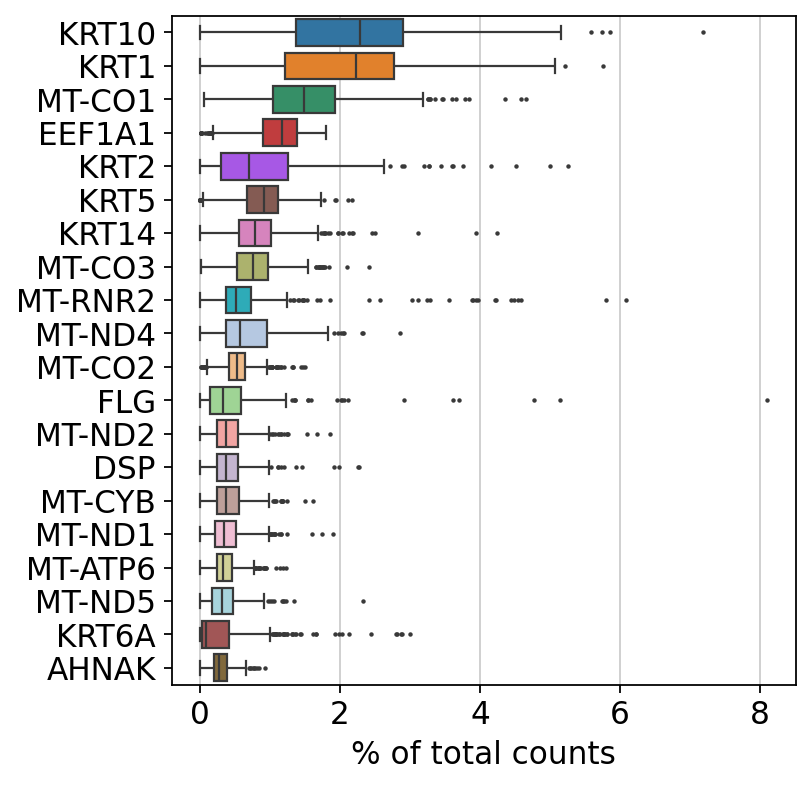

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


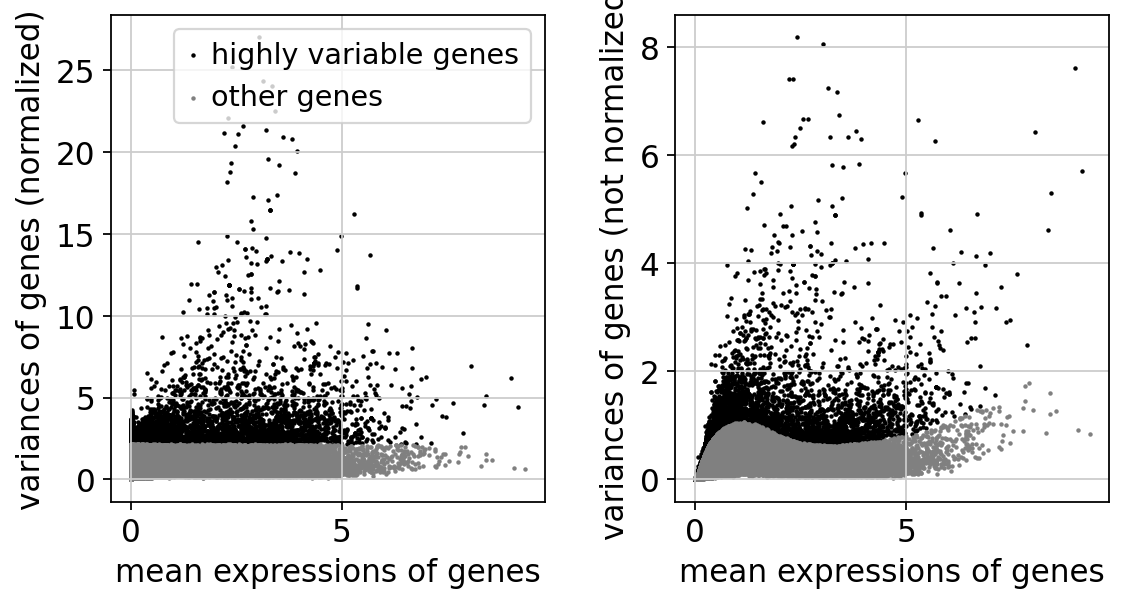

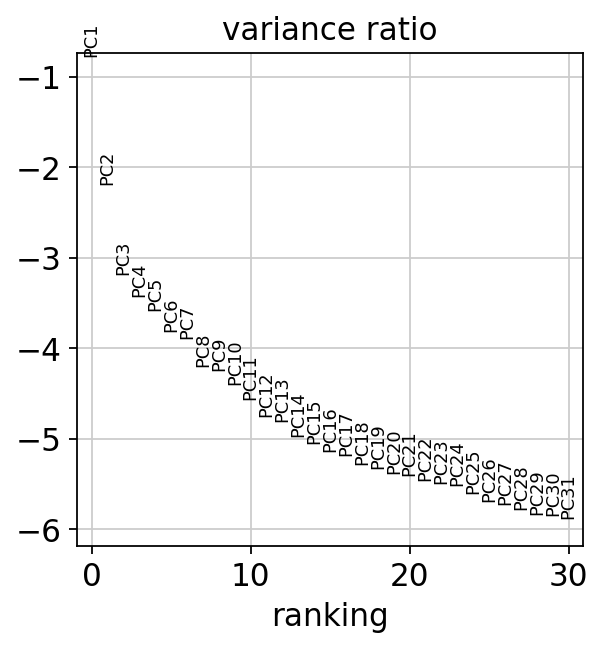

/tmp/ipykernel_9882/73940790.py:29: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=.5)


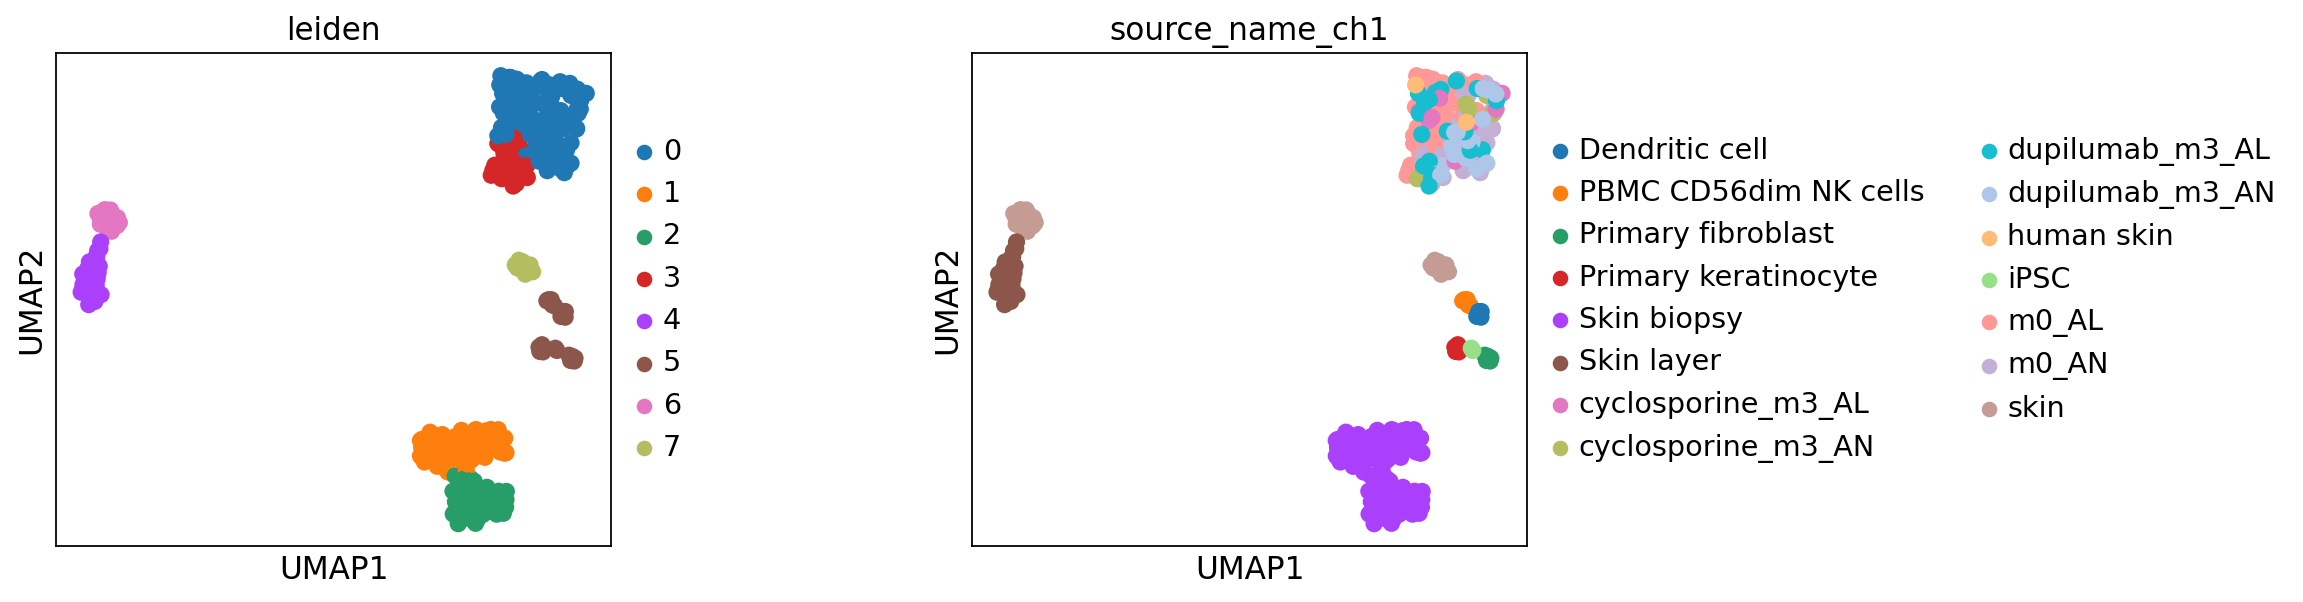

In [11]:
####    save raw counts and CPM to layers and freeze the raw data (CPMs) in .raw
adata.layers["salmon_counts"]=adata.X
sc.pp.normalize_total(adata, target_sum=1e6)
adata.layers["salmon_CPM"]=adata.X.copy()
# set raw data to salmon_CPM ### this is the data that will be used for coloring plots
adata.raw=adata.copy()
### now log
sc.pp.log1p(adata)
###  HVG selection 
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    #subset=True,
    #layer="salmon_counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)
### wait dont really filter forr HVG (HVGs still marked in adata.var['highly_variable'])
#adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

####### Computing the neighborhood graph
## reduce n_pcs if larger than number of samples or 50 
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.5)
adata

## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values are represented by grey
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))

sc.pl.umap(adata,
          color= ['leiden','source_name_ch1',#'characteristics_ch1'
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

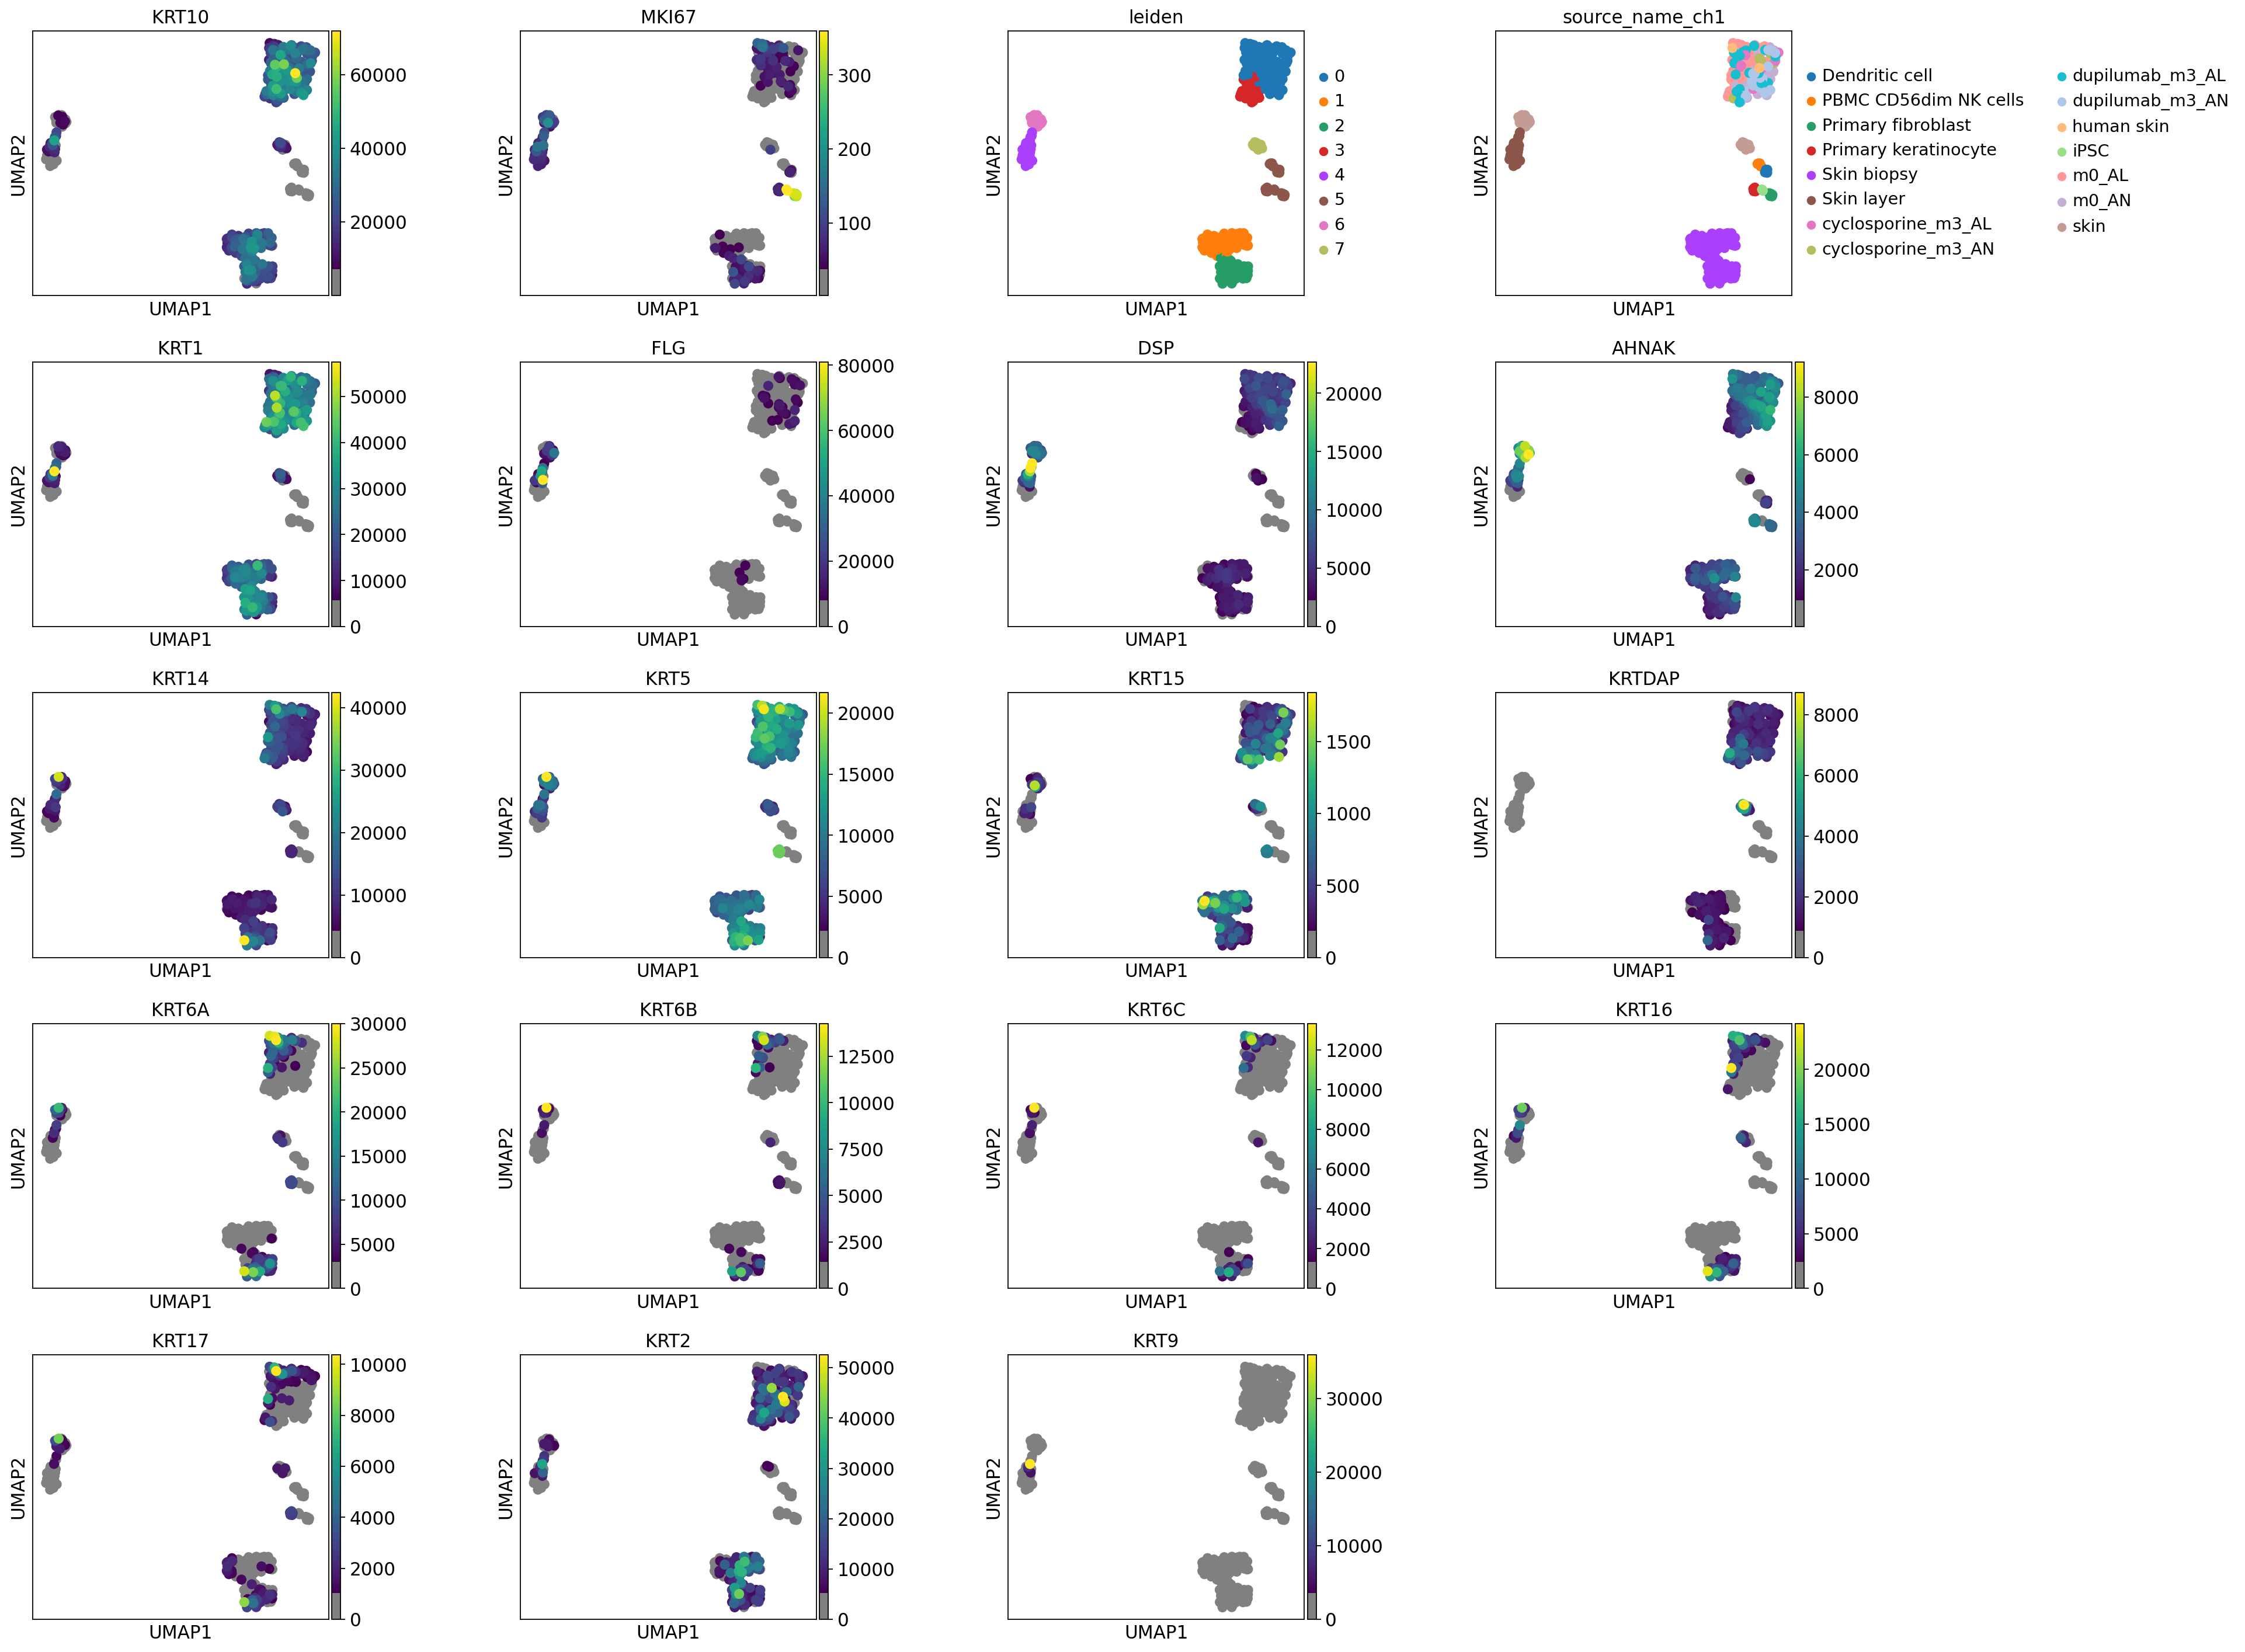

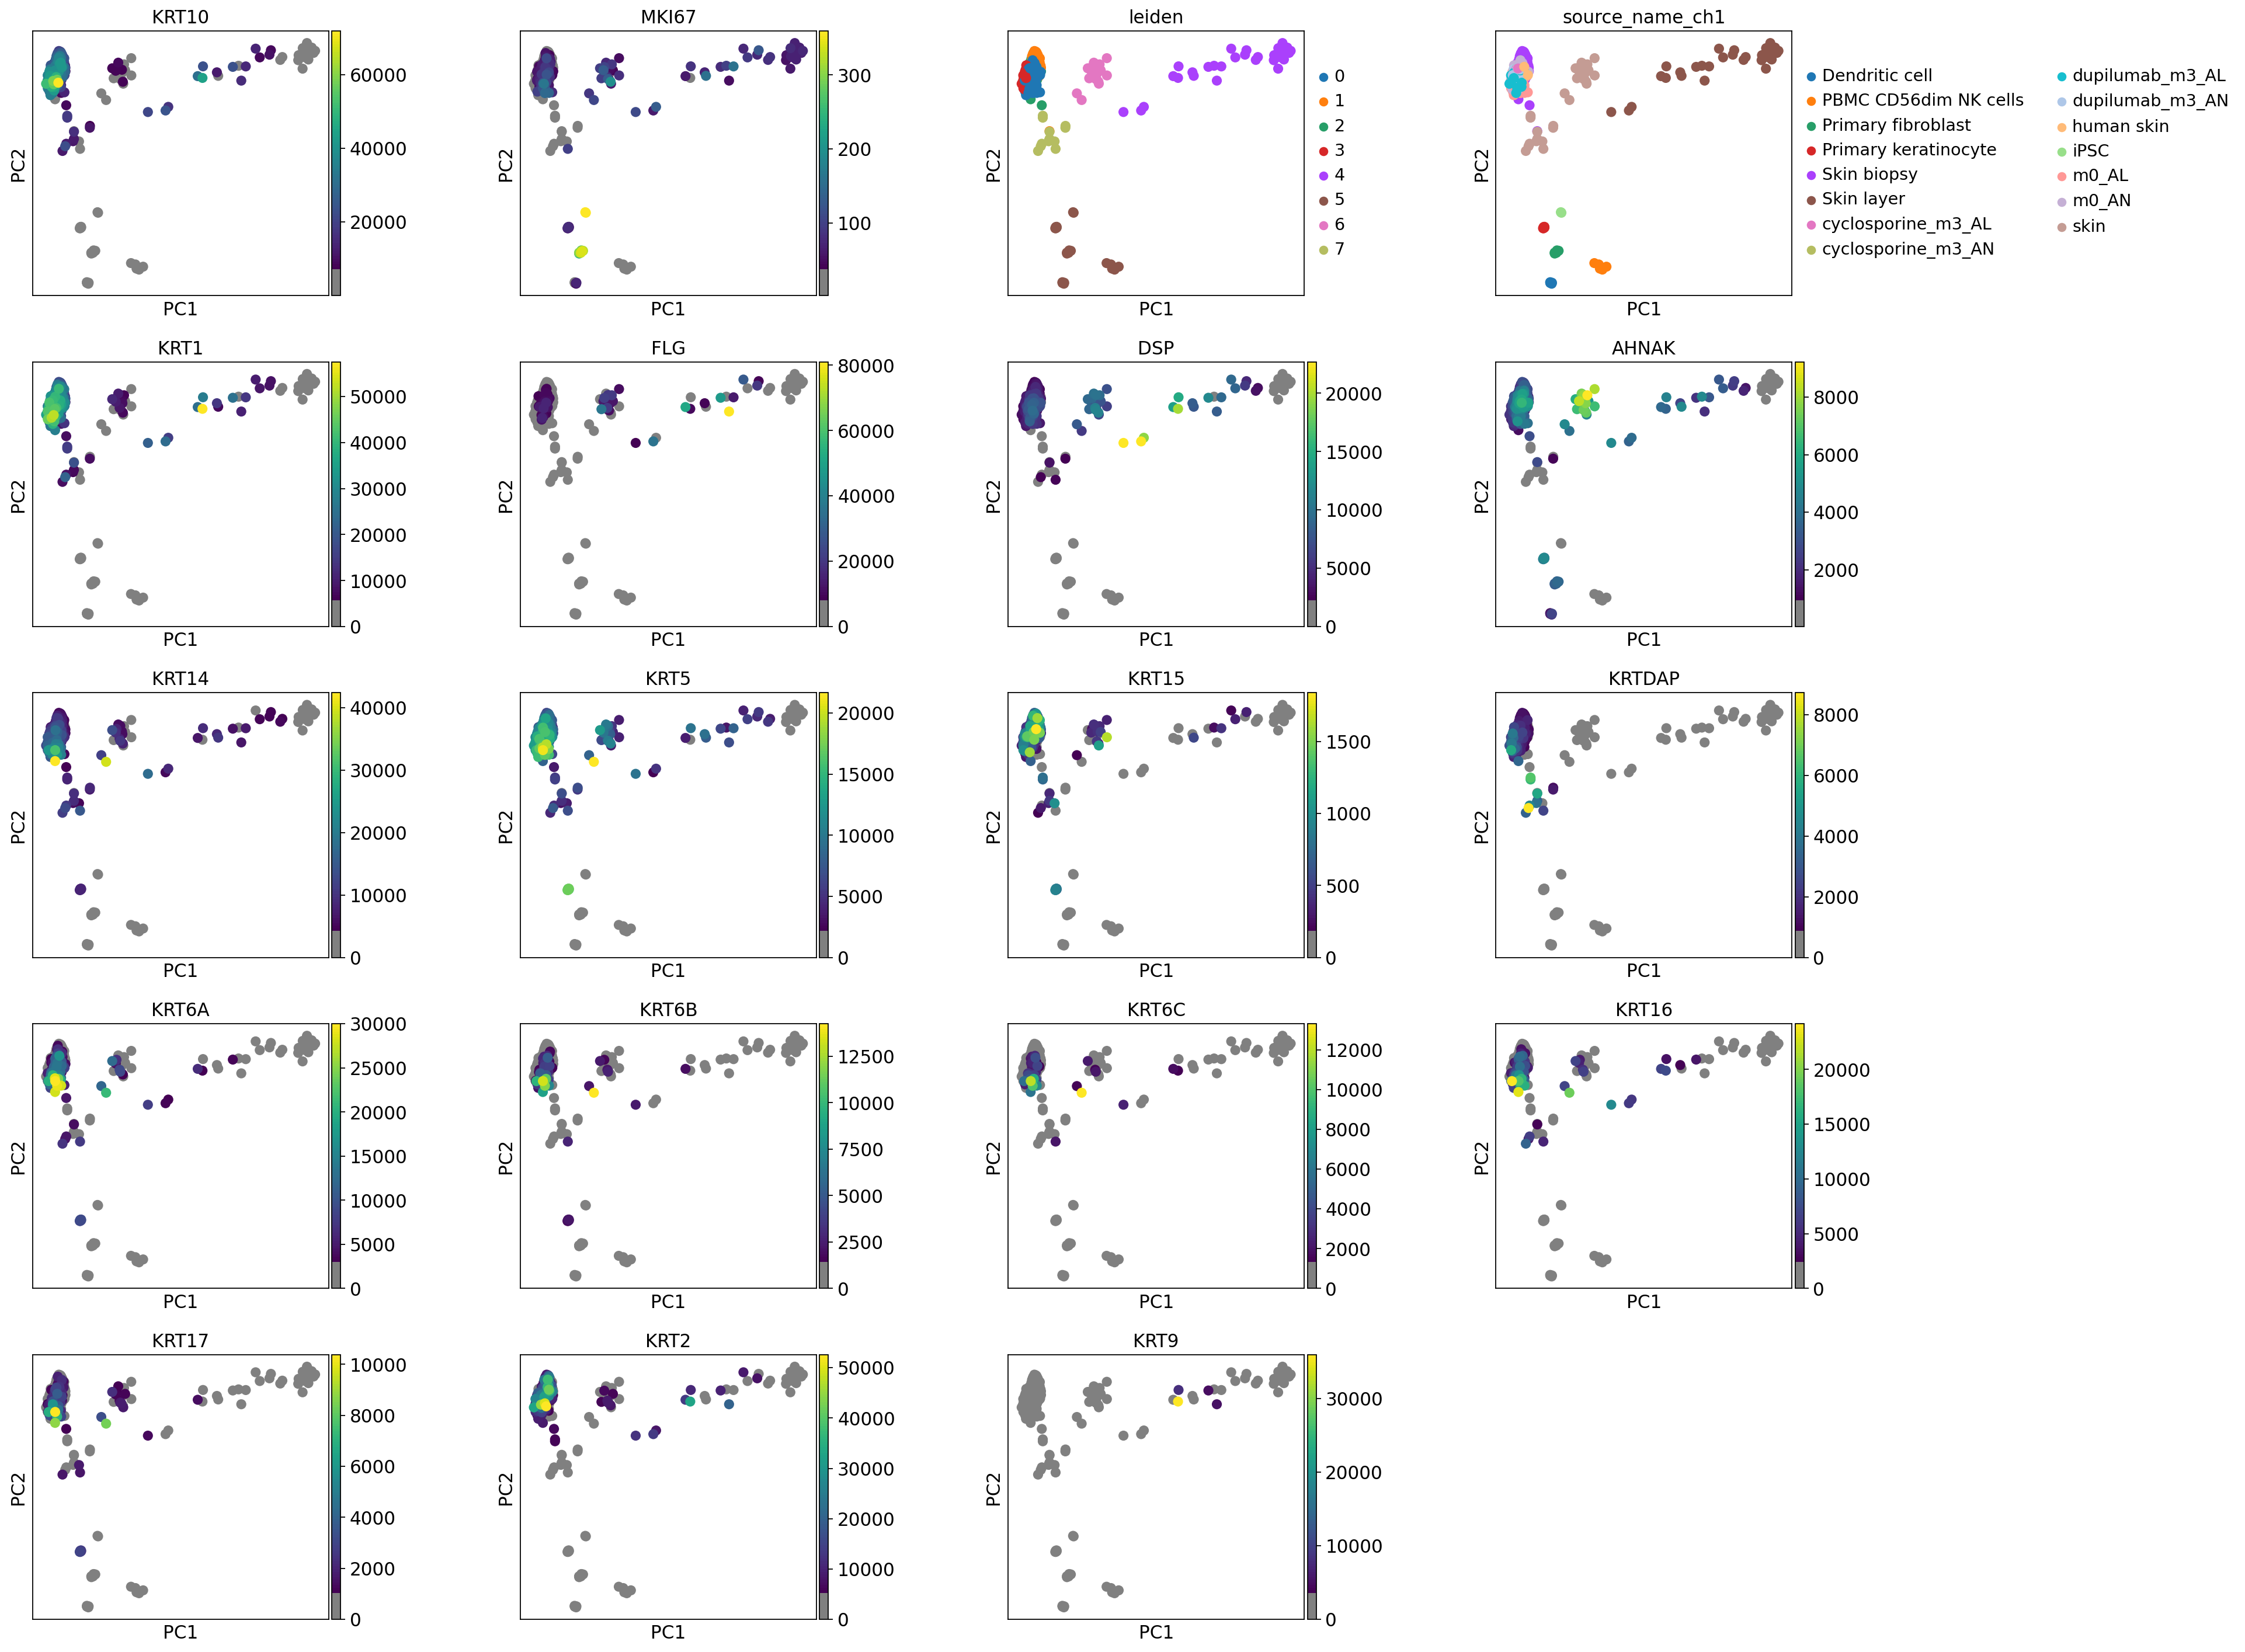

In [12]:
## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values are represented by grey
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))
sc.pl.umap(adata,
          color= [ 'KRT10','MKI67','leiden','source_name_ch1',
                 'KRT1','FLG','DSP',
                  'AHNAK','KRT14','KRT5','KRT15','KRTDAP','KRT6A','KRT6B','KRT6C','KRT16','KRT17','KRT2','KRT9'
                  ]
                  ,wspace=.5,ncols=4,size=240,cmap =cmap)

sc.pl.pca(adata,
          color= ['KRT10','MKI67','leiden','source_name_ch1',
                  'KRT1','FLG','DSP',
                  'AHNAK','KRT14','KRT5','KRT15','KRTDAP','KRT6A','KRT6B','KRT6C','KRT16','KRT17','KRT2','KRT9'
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

## now do some Differential Expression Analysis and Gene Set Enrichment Analysis based on the clusters 

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


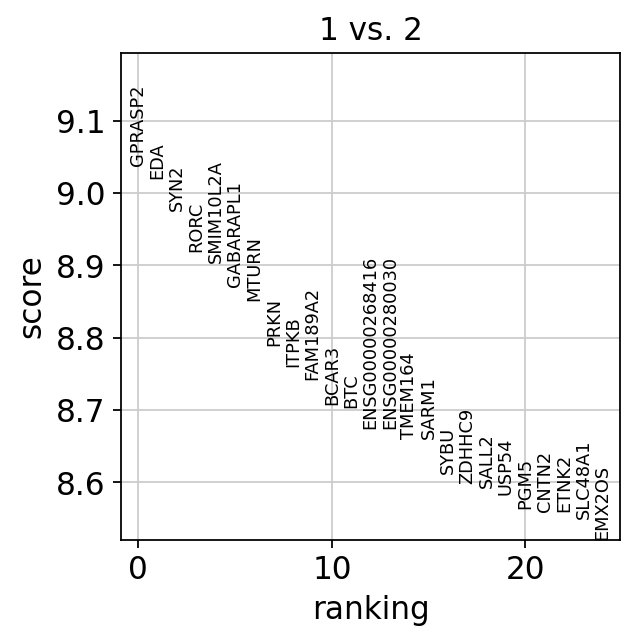

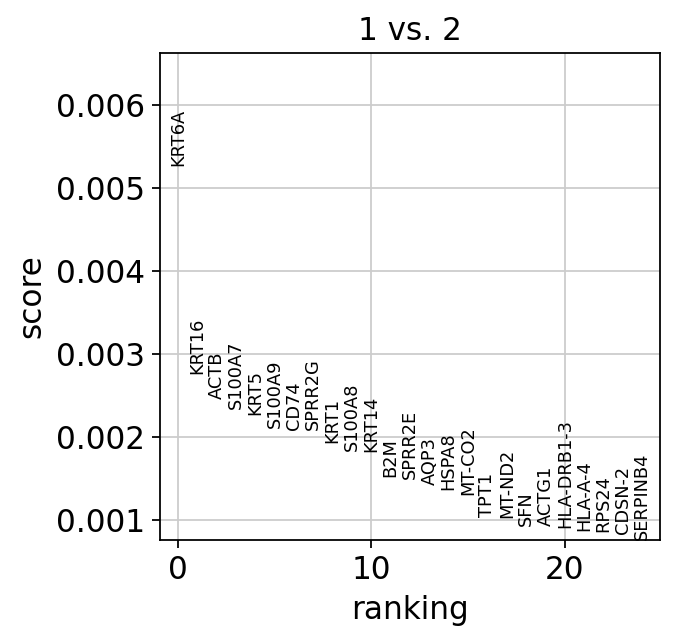

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


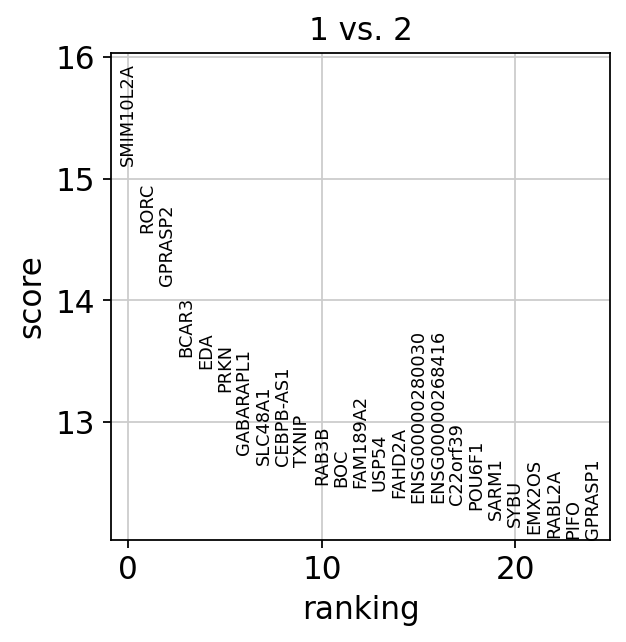

In [13]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test =rank_genes_obscat1_vs_obscat2(adata,wilcox=True,logreg=True,t_test=True,rank_use_raw=True,n_jobs=1,
                                  obs_key="leiden",obscat1='1',obscat2='2',)

In [14]:
rank_genes_groups_wilcox.head(4)

1_names  1_scores       1_pvals   1_pvals_adj  1_logfoldchanges
0  GPRASP2  9.038080  1.594469e-19  1.530371e-15          7.793307
1      EDA  9.018932  1.899318e-19  1.595095e-15          7.584086
2     SYN2  8.975848  2.811775e-19  2.099021e-15          7.553007
3     RORC  8.918403  4.730622e-19  3.014941e-15         33.235744

In [15]:
rank_genes_groups_logreg.head(4)

1
0   KRT6A
1   KRT16
2    ACTB
3  S100A7

In [16]:
rank_genes_groups_t_test.head(46)

1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges
0         SMIM10L2A  15.109164  4.082984e-30  2.743193e-25          5.314839
1              RORC  14.556238  4.941091e-28  1.659861e-23         33.235744
2           GPRASP2  14.120649  1.186841e-27  2.657971e-23          7.793307
3             BCAR3  13.534575  2.189413e-26  3.677448e-22         13.896504
4               EDA  13.437669  1.847316e-25  2.068563e-21          7.584086
5              PRKN  13.252100  1.147169e-25  1.541474e-21          3.836493
6         GABARAPL1  12.731086  6.484077e-24  4.840436e-20         40.649887
7           SLC48A1  12.650408  1.025963e-23  6.266396e-20         21.019997
8         CEBPB-AS1  12.636975  4.392237e-24  4.215669e-20          1.998299
9             TXNIP  12.633464  5.491621e-24  4.612001e-20               inf
10            RAB3B  12.485407  5.153456e-22  1.234582e-18         10.977216
11              BOC  12.464259  9.200230e-24  6.181266e-20         56.332054
12         FAM189A2  12.463118  1.733881e-23  8.960963e-20         22.275661
13            USP54  12.436620  1.726438e-23  8.960963e-20         32.902061
14           FAHD2A  12.377223  3.099940e-23  1.388484e-19         13.576522
15  ENSG00000280030  12.333583  5.400796e-22  1.234582e-18          9.841208
16  ENSG00000268416  12.333583  5.400796e-22  1.234582e-18          9.841208
17         C22orf39  12.320776  3.963446e-23  1.664300e-19         11.894950
18           POU6F1  12.275852  2.537011e-23  1.217511e-19         15.522462
19            SARM1  12.198647  4.616271e-23  1.824405e-19         11.752801
20             SYBU  12.139319  5.926140e-23  2.211965e-19         10.541445
21           EMX2OS  12.083196  7.731317e-23  2.733875e-19         19.213715
22           RABL2A  12.048877  7.686516e-22  1.665891e-18         13.756683
23             PIFO  12.035869  1.713412e-22  5.232606e-19          2.220960
24          GPRASP1  12.033797  1.242930e-22  3.976547e-19          8.248322
25           TMEM8B  12.030305  1.038025e-22  3.487036e-19         15.264660
26           TRIM45  11.922287  2.035571e-22  5.946168e-19          6.906288
27          TMEM108  11.867757  2.149714e-21  4.011963e-18          2.908403
28         ARHGAP44  11.844112  4.362216e-22  1.172319e-18          3.642868
29            JADE1  11.828510  3.187314e-22  8.922621e-19         16.736650
30            CGNL1  11.773127  5.512677e-22  1.234582e-18         35.915848
31       ZNF528-AS1  11.755217  5.108835e-22  1.234582e-18          4.554793
32              BTC  11.752187  1.365463e-20  2.085001e-17         28.967892
33             PGM5  11.728580  1.790678e-21  3.437386e-18         25.160929
34            SALL2  11.673312  1.168503e-21  2.379000e-18          5.826263
35            SNTB1  11.631463  1.123090e-21  2.357997e-18         18.397686
36         C1orf115  11.590288  9.002323e-21  1.475195e-17         25.929205
37            GPLD1  11.540787  1.636924e-21  3.234658e-18         14.718935
38            AGBL4  11.498622  4.213881e-20  4.966909e-17          2.165137
39             COG1  11.478933  3.603883e-20  4.483898e-17         16.371834
40          SLC2A11  11.450600  3.155366e-21  5.729634e-18          4.286797
41             SCIN  11.433125  9.575159e-21  1.531706e-17          7.151622
42           ZDHHC9  11.422507  8.001236e-21  1.343928e-17         66.031509
43         CACNA2D2  11.407868  2.969936e-20  3.864423e-17          6.218570
44            NPTXR  11.396692  1.151980e-20  1.799929e-17          4.799345
45            CNTN2  11.324455  2.990950e-20  3.864423e-17          4.238808

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


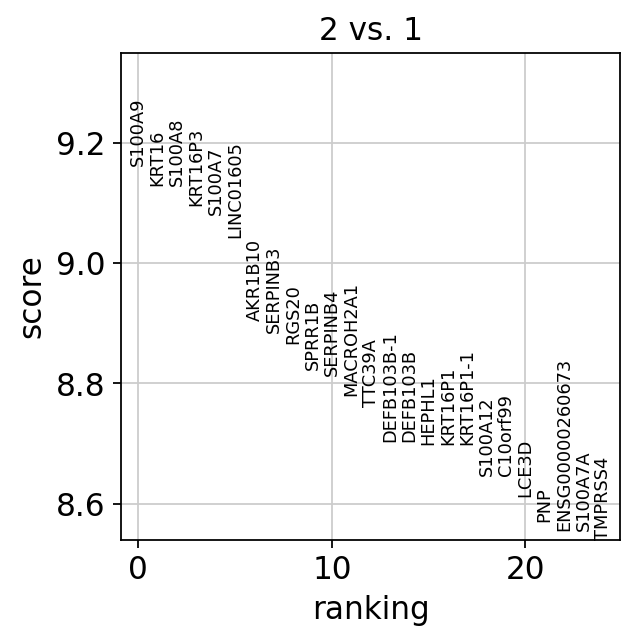

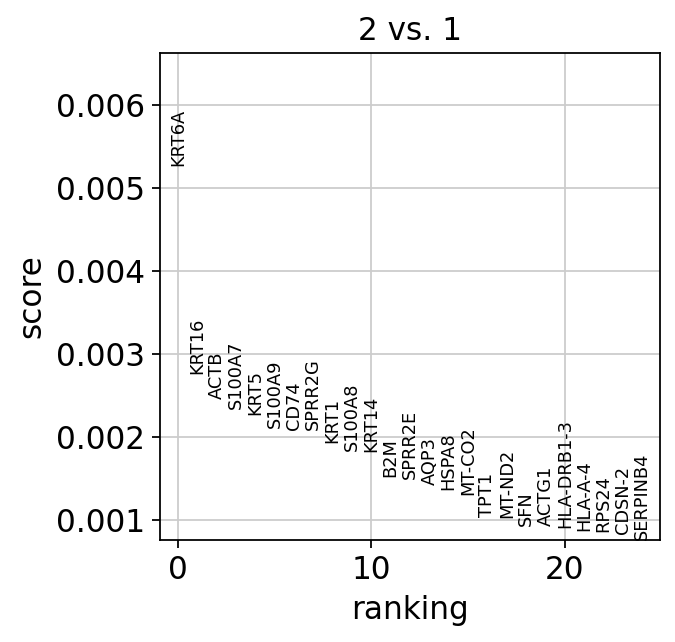

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


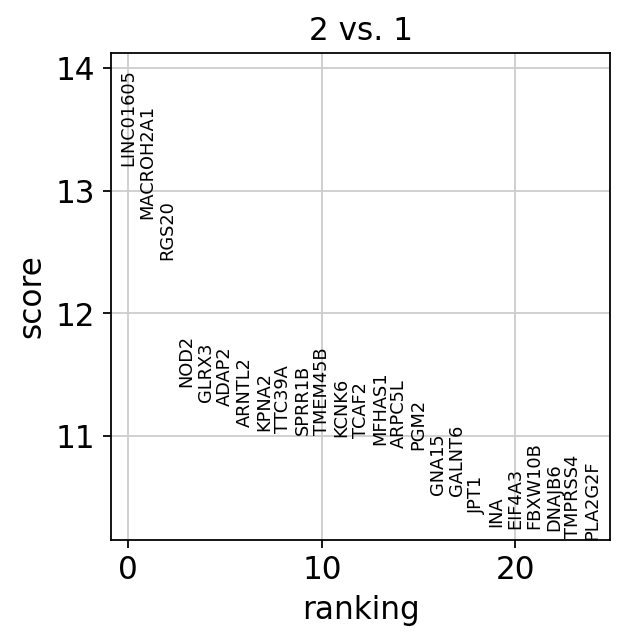

2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges
0         LINC01605  13.207497  2.636105e-19  2.393369e-16          8.886461
1         MACROH2A1  12.773262  1.824457e-20  2.723954e-17         93.885818
2             RGS20  12.439819  8.141051e-20  8.822011e-17          9.711777
3              NOD2  11.402066  5.921789e-18  3.825590e-15         41.146793
4             GLRX3  11.278069  7.155184e-18  4.535172e-15         38.958832
5             ADAP2  11.243198  8.553715e-18  5.258567e-15         34.903259
6            ARNTL2  11.073609  5.205978e-17  2.379380e-14         52.150593
7             KPNA2  11.042010  2.647754e-17  1.373005e-14         58.909611
8            TTC39A  11.024712  1.571683e-16  6.139248e-14         45.372658
9            SPRR1B  11.012225  8.714287e-16  2.723154e-13               inf
10          TMEM45B  11.004970  8.167738e-17  3.485559e-14         57.205883
11            KCNK6  10.990568  2.458100e-17  1.300393e-14        105.986336
12            TCAF2  10.983936  6.340495e-17  2.839950e-14         20.092506
13           MFHAS1  10.923982  5.013083e-17  2.306911e-14         35.361801
14           ARPC5L  10.903035  9.149845e-18  5.488764e-15         43.954727
15             PGM2  10.885811  2.976619e-17  1.500798e-14         57.580681
16            GNA15  10.516987  2.760854e-16  1.036261e-13         55.449818
17           GALNT6  10.510379  1.166980e-16  4.694894e-14         54.320297
18             JPT1  10.360545  2.964501e-17  1.500798e-14         24.803467
19              INA  10.261099  2.589587e-15  6.931634e-13          8.371610
20           EIF4A3  10.242472  1.682600e-15  4.831075e-13         61.344734
21          FBXW10B  10.239045  3.209456e-15  8.167823e-13          8.518749
22           DNAJB6  10.227035  3.339636e-16  1.219439e-13        103.882347
23          TMPRSS4  10.166337  9.017348e-15  2.006091e-12         50.532207
24          PLA2G2F  10.154016  2.122094e-15  5.795732e-13         96.356232
25            TUBB6  10.153749  1.464427e-15  4.334317e-13        115.399452
26            NCAPH  10.149860  2.261751e-15  6.102731e-13          8.442915
27             RCC1  10.128189  3.454851e-16  1.247944e-13         18.911879
28        SERPINB13  10.041205  3.565784e-14  6.673280e-12        133.228104
29           ACTR3C  10.026708  4.913461e-17  2.276661e-14          2.156707
30            PLBD1  10.018430  6.588776e-16  2.202356e-13         76.240128
31           DUOXA1   9.987637  8.401365e-15  1.894141e-12        145.281799
32  ENSG00000251455   9.963529  7.938516e-16  2.504024e-13          2.484324
33          FAM110C   9.891471  1.031437e-14  2.257267e-12         25.057583
34          AKR1B10   9.872315  7.544118e-14  1.270324e-11         63.637882
35              RAN   9.652901  8.477997e-15  1.905026e-12        137.216156
36             HPSE   9.617516  9.510397e-14  1.573807e-11         35.048309
37           FLVCR2   9.555391  2.281413e-14  4.616838e-12         12.837336
38            CCNB1   9.524801  4.865506e-14  8.779089e-12         25.498264
39             MELK   9.523893  8.534333e-14  1.422798e-11         10.440683
40             DBNL   9.446088  4.711766e-15  1.142833e-12         53.629772
41           ALYREF   9.438184  1.244611e-14  2.680141e-12         16.960552
42             IL4R   9.432624  8.290193e-14  1.385535e-11        100.488571
43             RRM2   9.425492  1.361685e-13  2.137528e-11         31.849865
44           EIF4A1   9.410022  1.411024e-14  3.000034e-12               inf
45              BLM   9.399097  5.524831e-14  9.717050e-12          3.612538

In [17]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = rank_genes_obscat1_vs_obscat2(adata,wilcox=True,logreg=True,t_test=True,rank_use_raw=True,n_jobs=1,
                                  obs_key="leiden",obscat1='2',obscat2='1',)
rank_genes_groups_t_test.head(46)

#### now do a comparison dif expression for all the clusters vs the rest

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

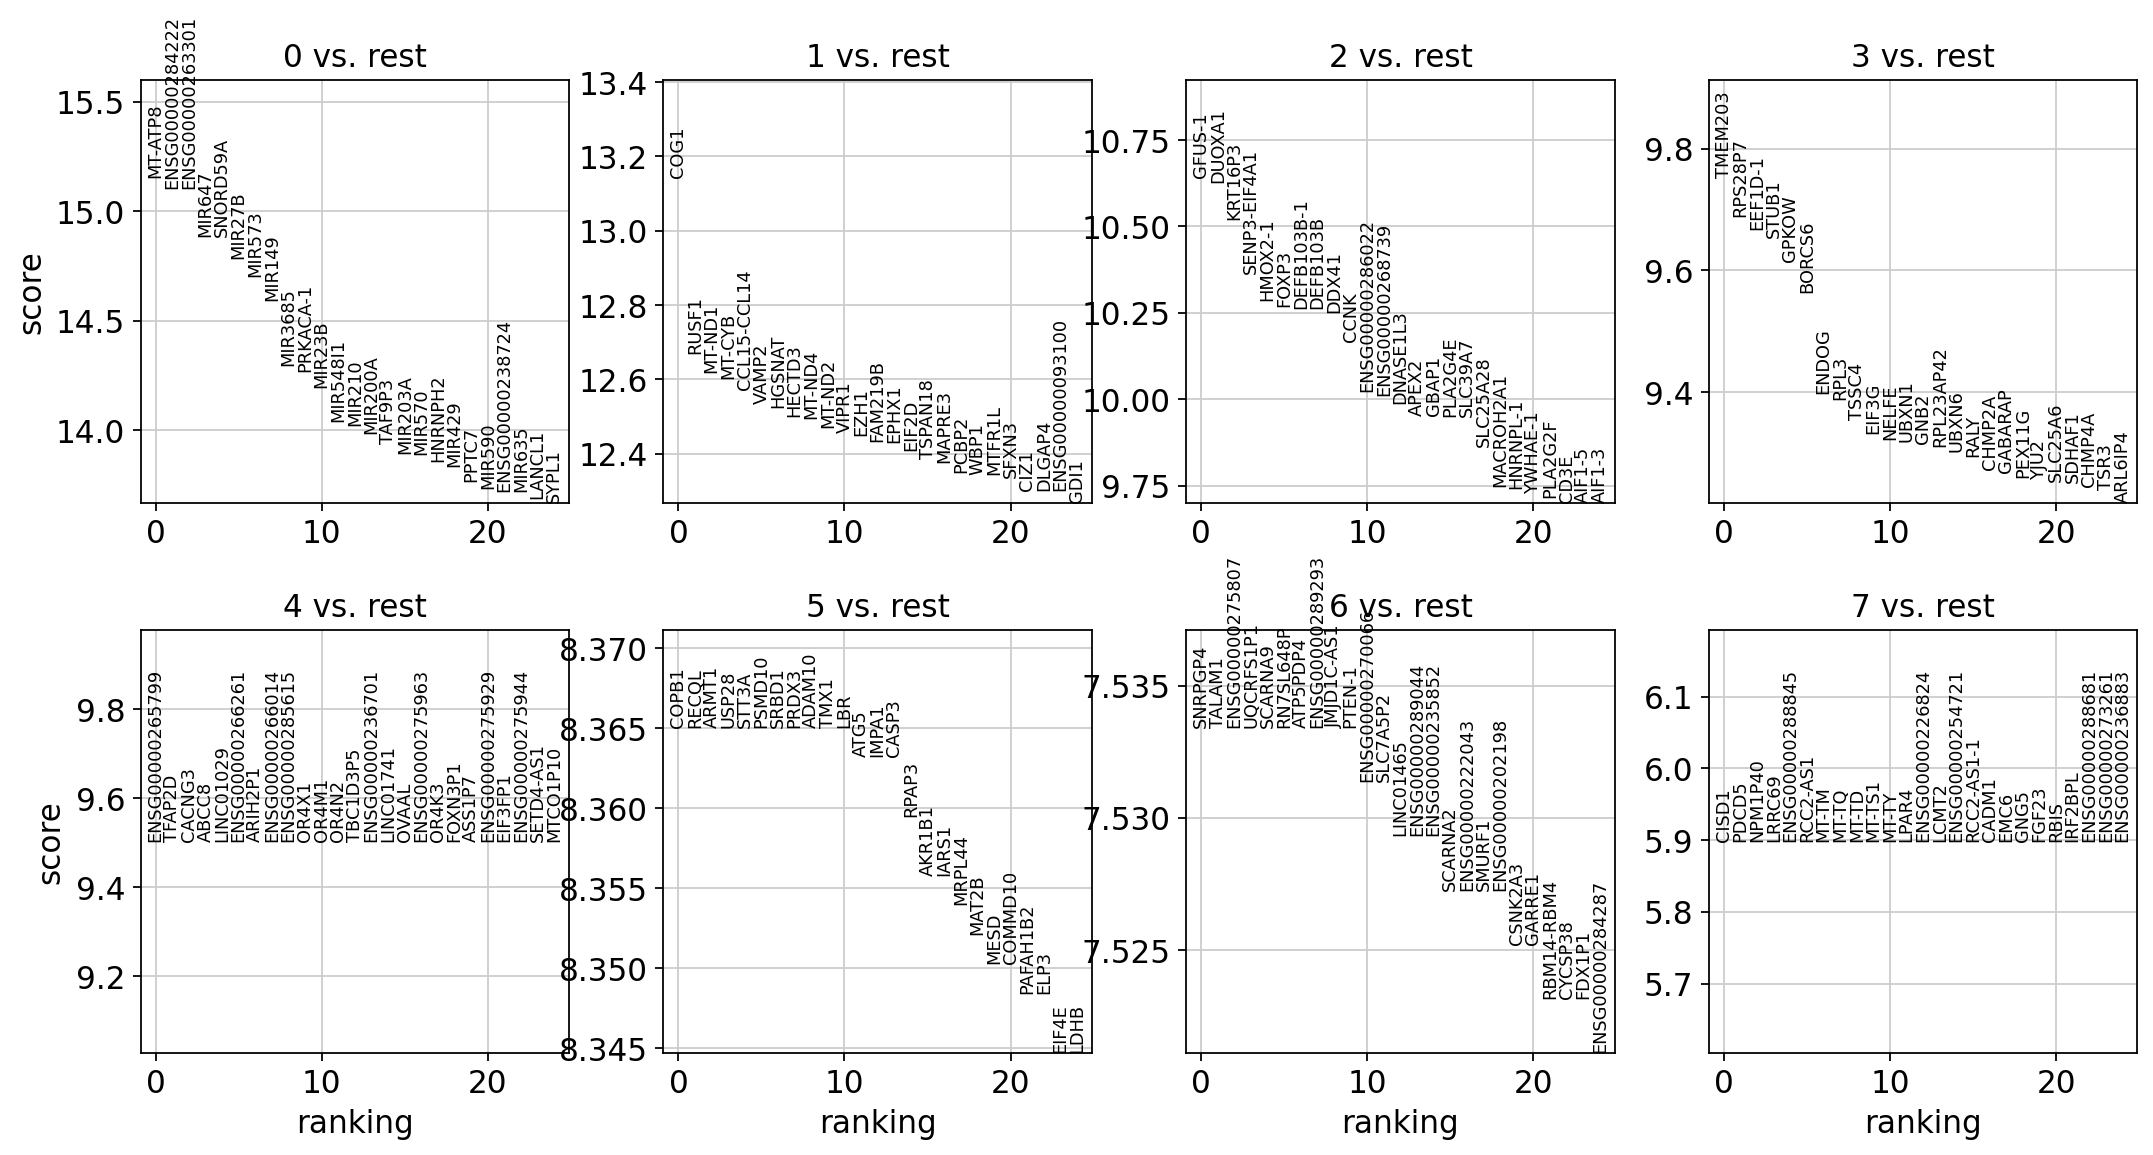

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


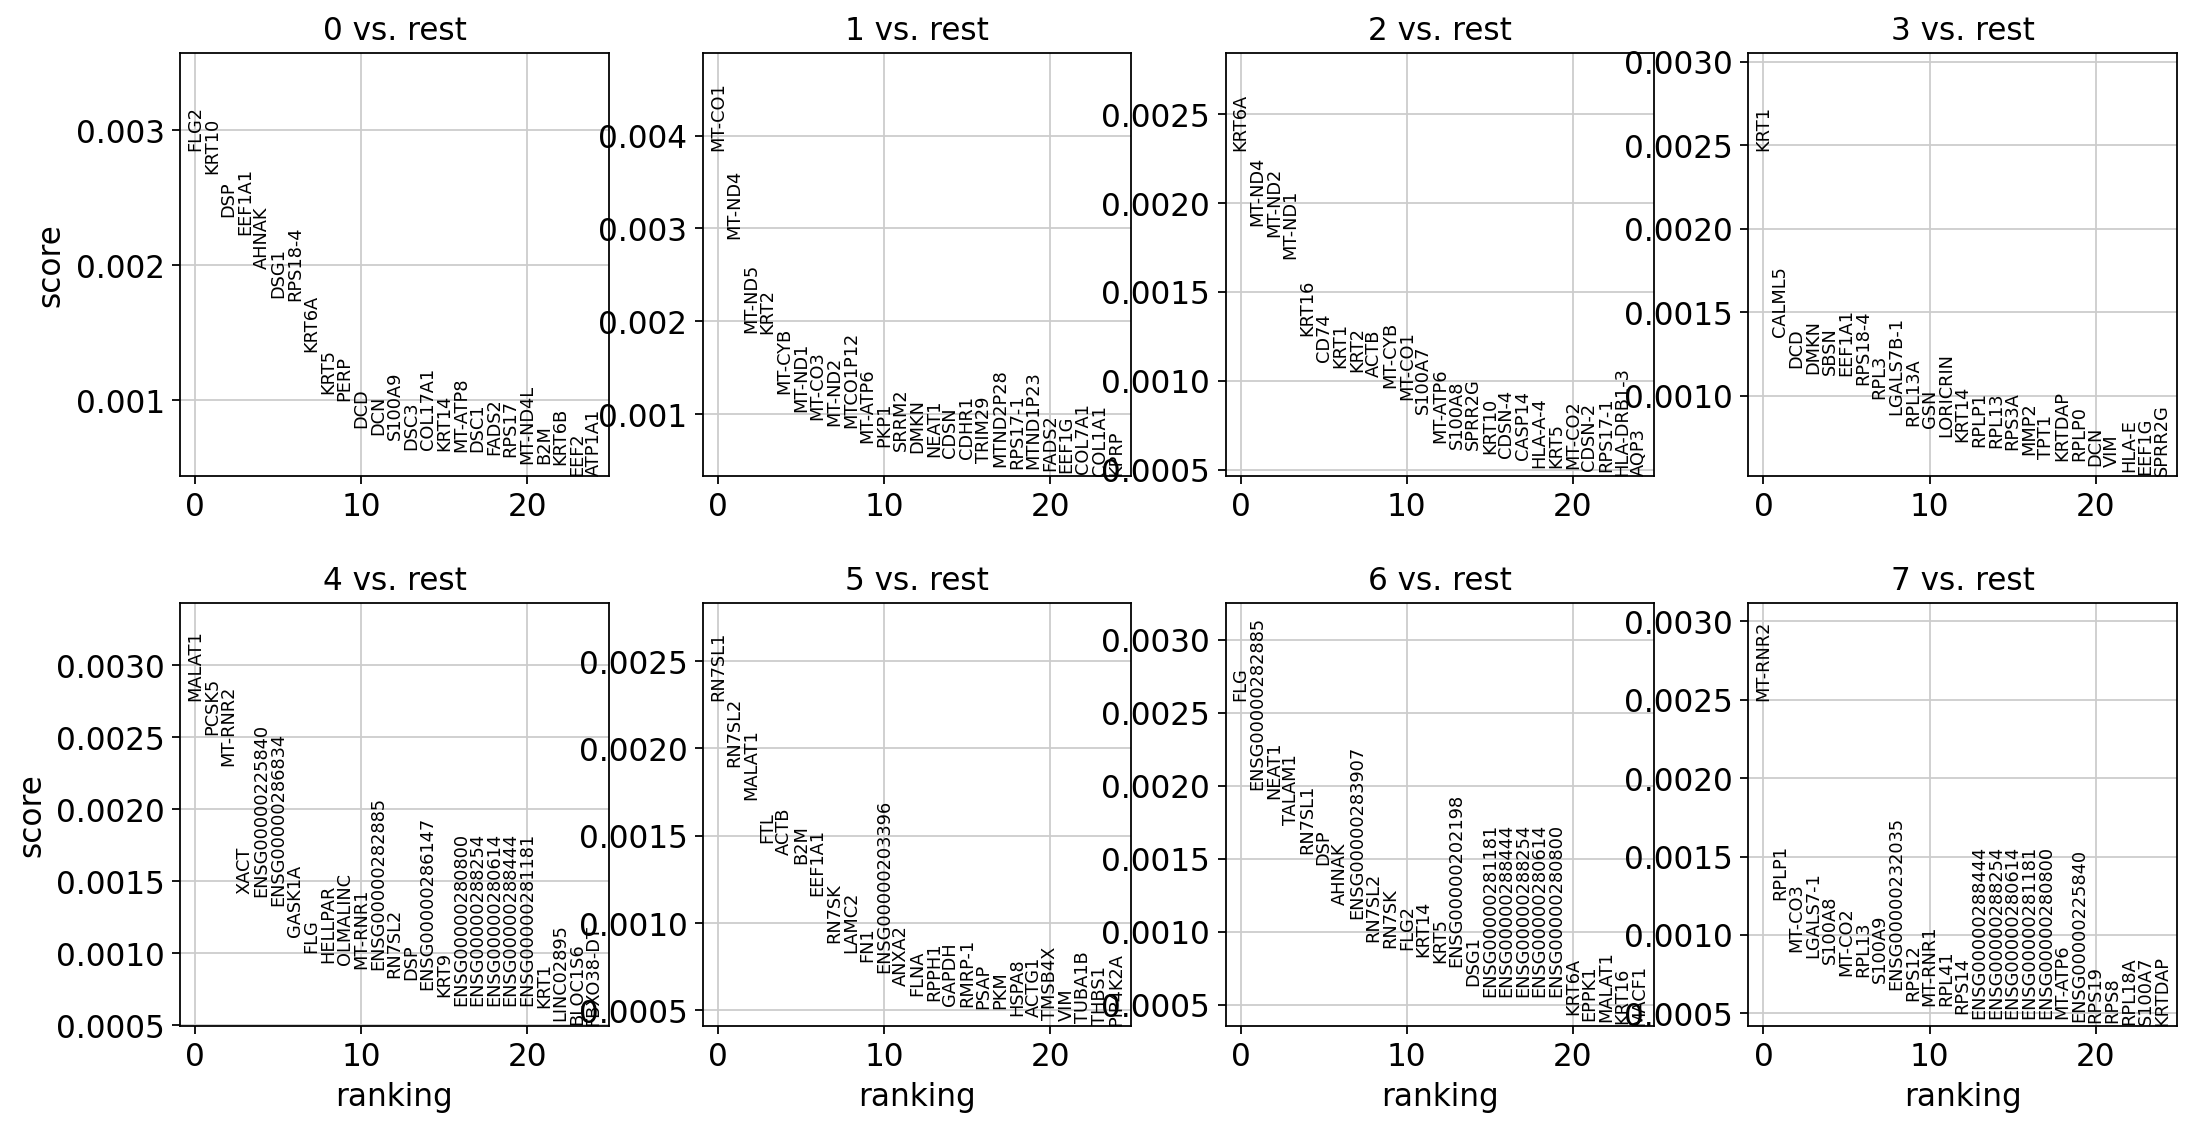

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

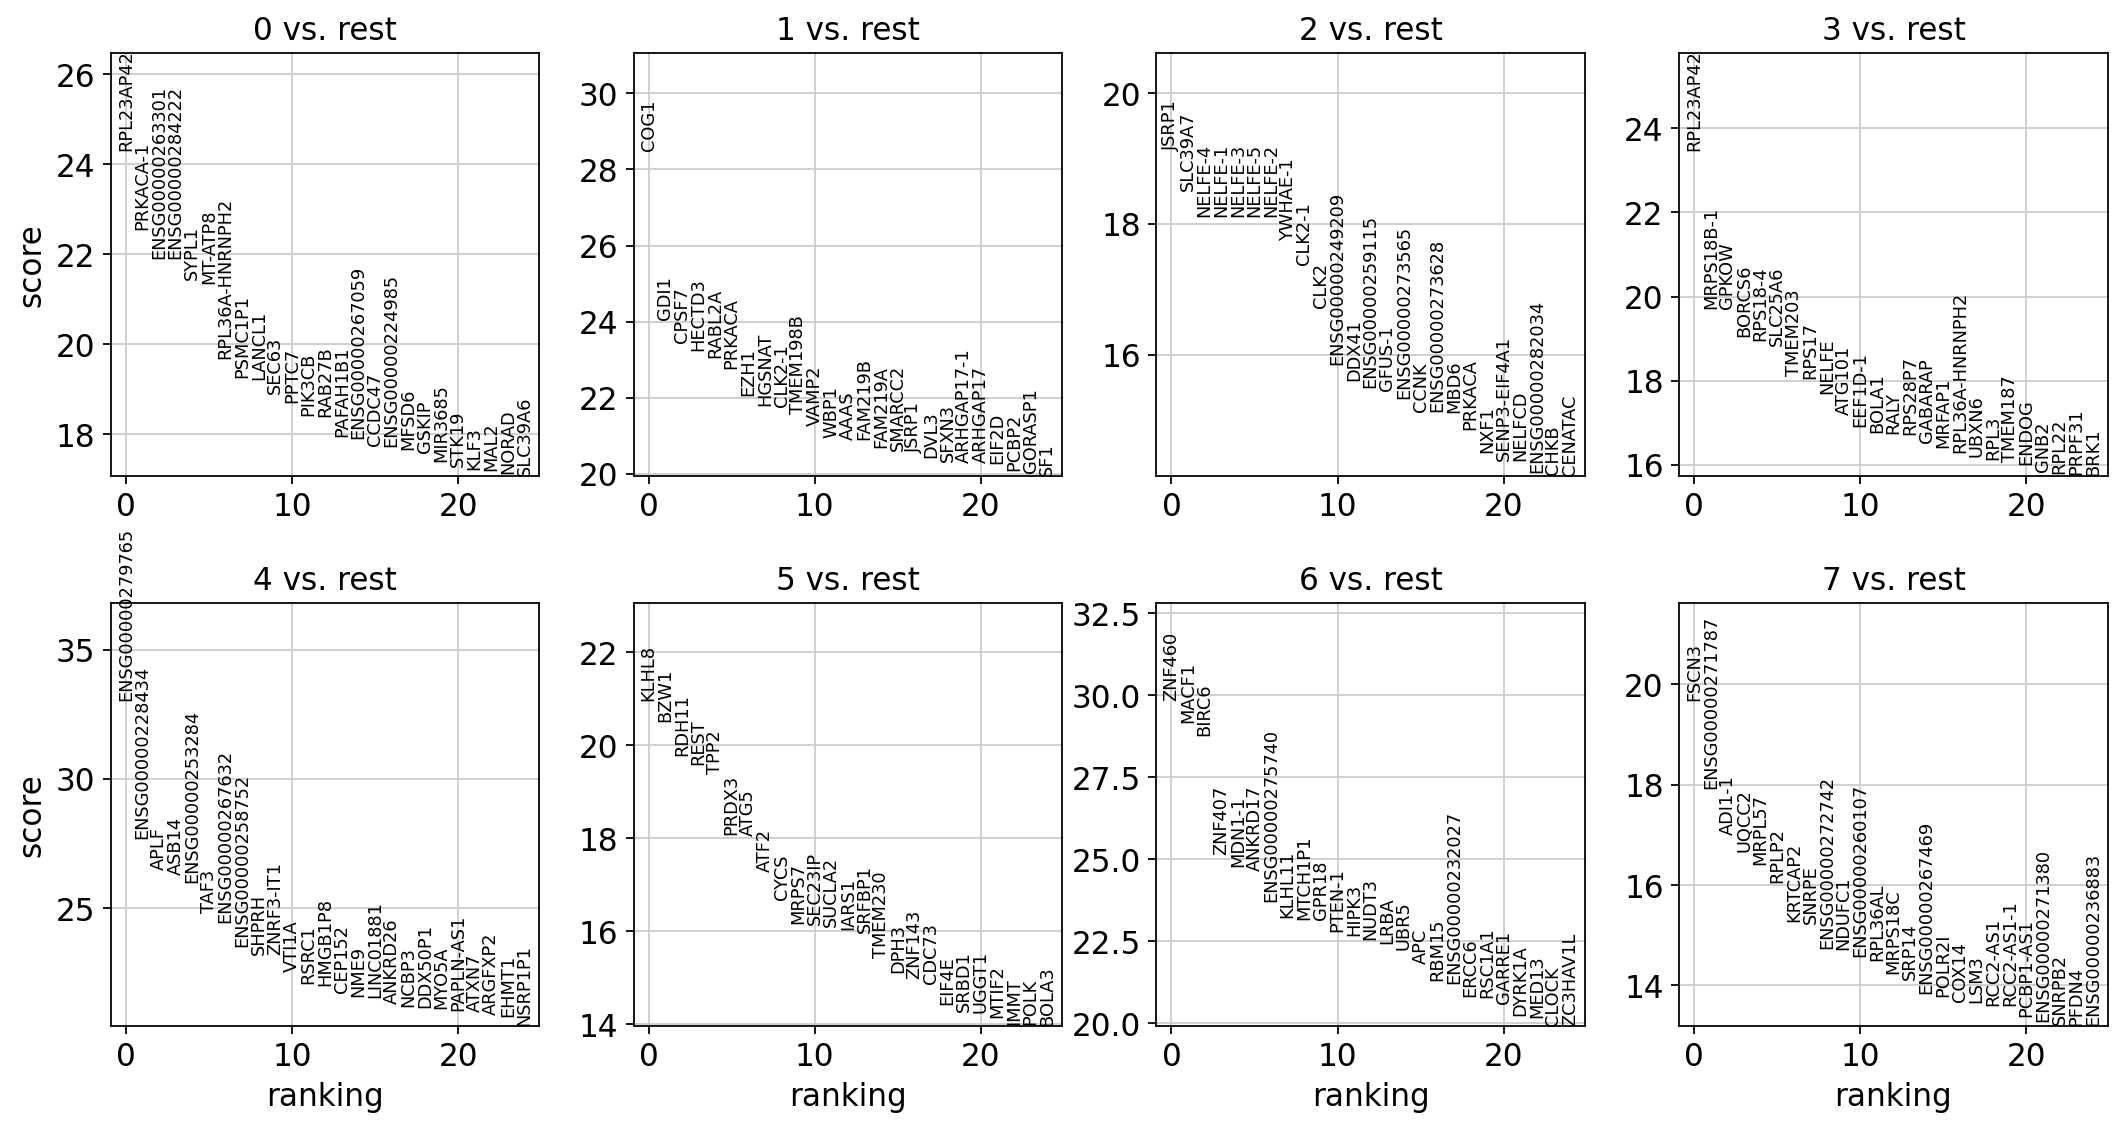

In [18]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = rank_genes(adata,
               wilcox=True,logreg=True,t_test=True,rank_use_raw=True,obs_key="leiden",
                 )

In [19]:
rank_genes_groups_wilcox.head(4)

0_names   0_scores       0_pvals   0_pvals_adj  0_logfoldchanges 1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges       2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges  3_names  3_scores       3_pvals   3_pvals_adj  3_logfoldchanges          4_names  4_scores       4_pvals   4_pvals_adj  4_logfoldchanges 5_names  5_scores       5_pvals   5_pvals_adj  5_logfoldchanges          6_names  6_scores       6_pvals   6_pvals_adj  6_logfoldchanges  7_names  7_scores       7_pvals   7_pvals_adj  7_logfoldchanges
0          MT-ATP8  15.154778  7.045324e-52  3.414397e-47        545.107361    COG1  13.143402  1.856864e-39  1.247553e-34         31.599499        GFUS-1  10.641759  1.904986e-26  7.586289e-22         92.305885  TMEM203  9.752967  1.791544e-22  7.909243e-18         30.033102  ENSG00000265799  9.503933  2.021093e-21  2.429904e-20        215.894287   COPB1   8.36506  6.008440e-17  1.269918e-14        344.562744          SNRPGP4  7.533431  4.942427e-14  3.723154e-11          4.735901    CISD1  5.898628  3.665362e-09  6.171821e-07         77.191025
1  ENSG00000284222  15.103974  1.524602e-51  3.414397e-47          2.876942   RUSF1  12.670972  8.564670e-37  2.877129e-32         56.584709        DUOXA1  10.625897  2.258294e-26  7.586289e-22        184.122345  RPS28P7  9.688823  3.363820e-22  7.909243e-18        125.491417           TFAP2D  9.503933  2.021093e-21  2.429904e-20         23.543928   RECQL   8.36506  6.008440e-17  1.269918e-14        131.368408           TALAM1  7.533431  4.942427e-14  3.723154e-11               inf    PDCD5  5.898628  3.665362e-09  6.171821e-07        118.700508
2  ENSG00000263301  15.103974  1.524602e-51  3.414397e-47          2.876942  MT-ND1  12.618353  1.672844e-36  3.442902e-32               NaN       KRT16P3  10.518832  7.074497e-26  1.584357e-21         46.710472  EEF1D-1  9.666921  4.167291e-22  7.909243e-18        159.707108           CACNG3  9.503933  2.021093e-21  2.429904e-20         16.774117   ARMT1   8.36506  6.008440e-17  1.269918e-14         65.494415  ENSG00000275807  7.533431  4.942427e-14  3.723154e-11          7.766903  NPM1P40  5.898628  3.665362e-09  6.171821e-07               inf
3           MIR647  14.886861  4.011647e-50  4.723192e-46          3.928083  MT-CYB  12.602338  2.049774e-36  3.442902e-32               NaN  SENP3-EIF4A1  10.362861  3.658538e-25  6.145063e-21         35.039280    STUB1  9.654405  4.708864e-22  7.909243e-18         88.664993            ABCC8  9.503933  2.021093e-21  2.429904e-20        125.092659   USP28   8.36506  6.008440e-17  1.269918e-14         81.829468        UQCRFS1P1  7.533431  4.942427e-14  3.723154e-11         30.093496   LRRC69  5.898628  3.665362e-09  6.171821e-07        608.715698

In [20]:
rank_genes_groups_logreg.head(4)

0       1       2       3        4       5                6         7
0    FLG2  MT-CO1   KRT6A    KRT1   MALAT1  RN7SL1              FLG   MT-RNR2
1   KRT10  MT-ND4  MT-ND4  CALML5    PCSK5  RN7SL2  ENSG00000282885     RPLP1
2     DSP  MT-ND5  MT-ND2     DCD  MT-RNR2  MALAT1            NEAT1    MT-CO3
3  EEF1A1    KRT2  MT-ND1    DMKN     XACT     FTL           TALAM1  LGALS7-1

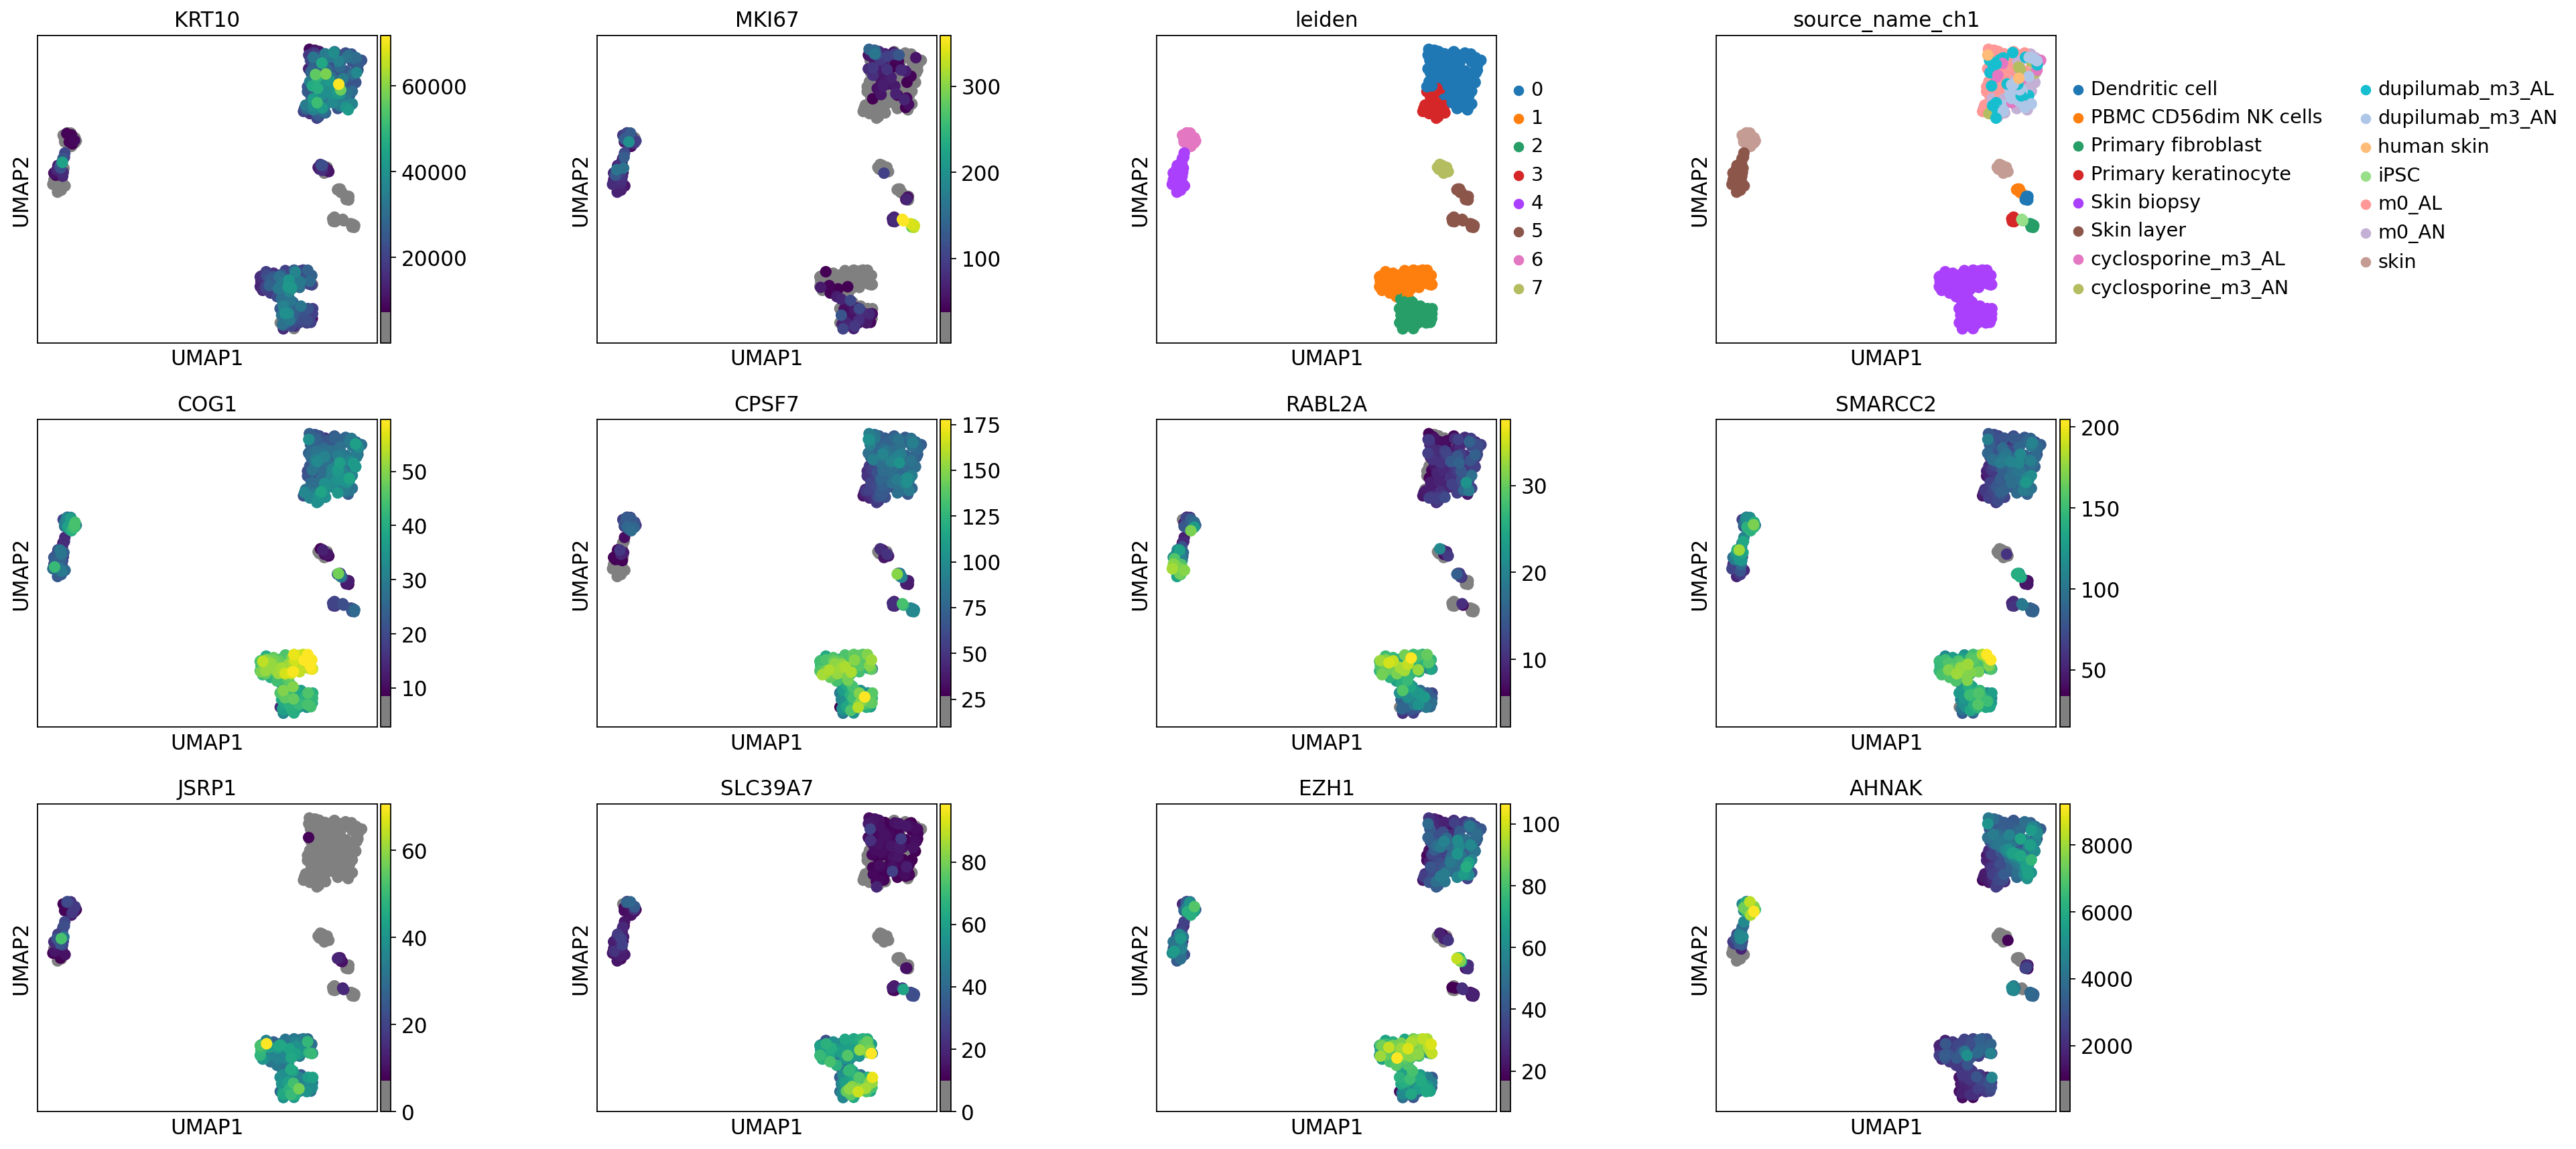

In [21]:
sc.pl.umap(adata,
          color= [ 'KRT10','MKI67','leiden','source_name_ch1',
                   'COG1','CPSF7','RABL2A','SMARCC2',
                 'JSRP1','SLC39A7','EZH1','AHNAK',
                  ]
                  ,wspace=.5,ncols=4,size=240,cmap =cmap)


In [22]:
rank_genes_groups_t_test.head(40)

0_names   0_scores       0_pvals   0_pvals_adj  0_logfoldchanges          1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges          2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges         3_names   3_scores       3_pvals   3_pvals_adj  3_logfoldchanges          4_names   4_scores       4_pvals   4_pvals_adj  4_logfoldchanges   5_names   5_scores       5_pvals   5_pvals_adj  5_logfoldchanges          6_names   6_scores       6_pvals   6_pvals_adj  6_logfoldchanges          7_names   7_scores       7_pvals   7_pvals_adj  7_logfoldchanges
0         RPL23AP42  24.309843  2.272593e-76  1.526864e-71        404.226227             COG1  28.501112  4.773593e-71  1.603593e-66         31.599499            JSRP1  19.123478  3.830725e-39  6.599259e-36         36.957691       RPL23AP42  23.473465  5.447870e-42  3.485910e-39        485.512329  ENSG00000279765  33.041996  6.638451e-32  1.572122e-30         48.916313     KLHL8  20.969736  2.099603e-19  5.016498e-18         22.014809           ZNF460  29.847591  1.389982e-18  9.617648e-17        144.430328            FSCN3  19.685768  6.163174e-10  5.327145e-09        142.571228
1          PRKACA-1  22.543615  2.538911e-63  4.264481e-59         21.432325             GDI1  24.063631  5.811613e-62  7.809180e-58         94.793907          SLC39A7  18.515764  3.227875e-32  2.383165e-29         60.027756       MRPS18B-1  19.721924  3.809079e-35  8.675145e-33         50.515587  ENSG00000228434  27.683804  1.080177e-24  1.963549e-23         91.559494      BZW1  20.506639  6.910795e-18  1.516358e-16        540.512695            MACF1  29.161116  3.304795e-19  2.439956e-17               inf  ENSG00000271787  17.930290  9.950099e-10  8.262358e-09         18.833002
2   ENSG00000263301  21.900103  3.891367e-55  1.742969e-51          2.876942            CPSF7  23.445917  1.245252e-63  2.091588e-59         86.062592          NELFE-4  18.109579  2.059791e-34  2.095619e-31          6.005492           GPKOW  19.715588  5.467064e-28  4.452244e-26         19.327042             APLF  26.493811  1.038096e-24  1.888586e-23         31.915468     RDH11  19.783789  1.486310e-24  4.688227e-23        111.001274            BIRC6  28.772257  5.022924e-19  3.628712e-17        471.915649           ADI1-1  17.003548  2.790842e-09  2.086408e-08         74.656174
3   ENSG00000284222  21.900103  3.891367e-55  1.742969e-51          2.876942           HECTD3  23.249207  3.621803e-58  2.703716e-54         64.345413          NELFE-1  18.109579  2.059791e-34  2.095619e-31          6.005492          BORCS6  19.055380  1.281793e-25  7.508157e-24         16.278469            ASB14  26.295309  6.285604e-26  1.204176e-24         10.888110      REST  19.578203  3.003270e-18  6.712499e-17         89.907211           ZNF407  25.138113  1.344761e-18  9.323952e-17         55.347878            UQCC2  16.676283  2.558644e-09  1.930216e-08        126.070740
4             SYPL1  21.449568  1.037716e-67  2.324000e-63        113.561668           RABL2A  23.052496  3.982809e-54  1.163430e-50         20.754452          NELFE-3  18.109579  2.059791e-34  2.095619e-31          6.005492         RPS18-4  18.965347  3.408207e-28  2.848057e-26               NaN  ENSG00000253284  25.985712  5.361804e-25  9.896653e-24         22.521086      TPP2  19.401457  2.577133e-18  5.790878e-17         94.898315           MDN1-1  24.769211  2.089518e-17  1.251216e-15        222.019119           MRPL57  16.404333  4.059240e-09  2.925825e-08        139.337860
5           MT-ATP8  21.355350  1.016507e-48  1.552160e-45        545.107361           PRKACA  22.760971  6.004323e-50  1.260645e-46         73.711922          NELFE-5  18.109579  2.059791e-34  2.095619e-31          6.005492         SLC25A6  18.829464  7.060521e-29  6.533997e-27        345.543274             TAF3  24.851681  1.760186e-23  3.047934e-22         54.752983     PRDX3  18.089828  1.102381e-15  2.083391e-14        253.591705          ANKRD17  24.669296  1.337633e-17  8.153574

# step by step example for loading ARCHS4_H5_file and extracting subset of samples into an adata

### load data

In [23]:
!h5ls -r /home/ubuntu/data/ARCHS4/human_gene_v2.2.h5

/                        Group
/data                    Group
/data/expression         Dataset {67186, 722425/Inf}
/meta                    Group
/meta/genes              Group
/meta/genes/biotype      Dataset {67186}
/meta/genes/ensembl_gene_id Dataset {67186}
/meta/genes/symbol       Dataset {67186}
/meta/info               Group
/meta/info/author        Dataset {SCALAR}
/meta/info/contact       Dataset {SCALAR}
/meta/info/creation-date Dataset {SCALAR}
/meta/info/laboratory    Dataset {SCALAR}
/meta/info/version       Dataset {SCALAR}
/meta/samples            Group
/meta/samples/channel_count Dataset {722425}
/meta/samples/characteristics_ch1 Dataset {722425}
/meta/samples/contact_address Dataset {722425}
/meta/samples/contact_city Dataset {722425}
/meta/samples/contact_country Dataset {722425}
/meta/samples/contact_institute Dataset {722425}
/meta/samples/contact_name Dataset {722425}
/meta/samples/contact_zip Dataset {722425}
/meta/samples/data_processing Dataset {722425}
/meta/sa

In [24]:
%%time

#from G.ARCHS4_H5_file
print(G.ARCHS4_H5_file) 
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
print("Groups in HDF5 file:")
for group in list(ARCHS4_H5.keys()):
    print(group)
    for sub_group in list(ARCHS4_H5[group].keys()):
        print(f'    {sub_group}')
   



/home/ubuntu/data/ARCHS4/human_gene_v2.2.h5
Groups in HDF5 file:
data
    expression
meta
    genes
    info
    samples
CPU times: user 1.49 ms, sys: 5 μs, total: 1.5 ms
Wall time: 2.1 ms


### load the metadata

In [25]:
df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
print(df_meta_src.shape)
#df_meta_src.to_csv('meta_samples.csv', index=False)
#df_meta_src=pd.read_csv('meta_samples.csv')
df_meta=df_meta_src.copy()
df_meta.head(2)

(722425, 30)


geo_accession                             title type                 characteristics_ch1       source_name_ch1      sample series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation     contact_name             contact_address contact_city contact_zip contact_country contact_institute
0    GSM1000981  OCI-LY1_48hrs_mRNAseq_3x_siNT_R1  SRA  treatment: siNT,cell line: OCI-LY1  Human DLBCL cel line  GSM1000981  GSE29282    total RNA  ChIP-seq libraries were prepared using the Ill...     102963402              cDNA  transcriptomic          RNA-Seq               0.007336     Sep 10 2012  ChIP-seq: Raw images generated went through pr...  Public on Aug 05 2013      May 15 2019             1  Homo sapiens      9606    GPL15433  Illumina HiSeq 1000  SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...  Katerina,,Hatzi  413 E 69th Street, BB-1462     New York                         USA              WCMC
1    GSM1000982  OCI-LY1_48hrs_mRNAseq_3x_siNT_R2  SRA  treatment: siNT,cell line: OCI-LY1  Human DLBCL cel line  GSM1000982  GSE29282    total RNA  ChIP-seq libraries were prepared using the Ill...      85980162              cDNA  transcriptomic          RNA-Seq              -0.006492     Sep 10 2012  ChIP-seq: Raw images generated went through pr...  Public on Aug 05 2013      May 15 2019             1  Homo sapiens      9606    GPL15433  Illumina HiSeq 1000  SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...  Katerina,,Hatzi  413 E 69th Street, BB-1462     New York                         USA              WCMC

#### check out the compositin of columns

organism_ch1
Homo sapiens    722425
Name: count, dtype: int64
library_strategy
RNA-Seq    722425
Name: count, dtype: int64
library_selection
cDNA                  719170
CAGE                    2080
size fractionation       874
RACE                     265
RANDOM                    20
other                     16
Name: count, dtype: int64
molecule_ch1
total RNA          526089
polyA RNA          194774
nuclear RNA           718
genomic DNA           464
cytoplasmic RNA       263
protein                82
other                  35
Name: count, dtype: int64


<Axes: >

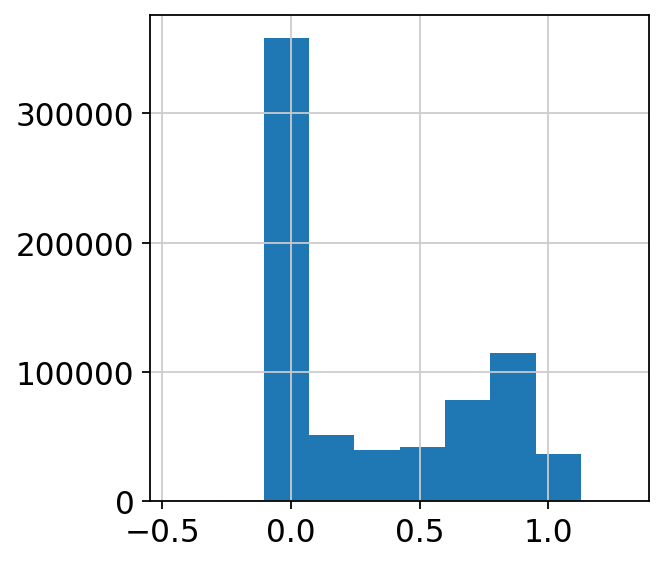

In [26]:
print(df_meta['organism_ch1'].value_counts())
print(df_meta['library_strategy'].value_counts())
print(df_meta['library_selection'].value_counts())
print(df_meta['molecule_ch1'].value_counts()) # RNA
#print(df['type'].value_counts())
#print(df['status'].value_counts())
#print(df['platform_id'].value_counts())
#print(df['instrument_model'].value_counts())
#print(df['relation'].value_counts())
#print(df['series_id'].value_counts())
#print(df['sra_id'].value_counts())
#print(df['data_processing'].value_counts())
df_meta['singlecellprobability'].hist()

### filter  the data

#### now do a basic filter for RNA gene expression and some cut off for single cell probability

(722425, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.2
(398669, 30)


<Axes: >

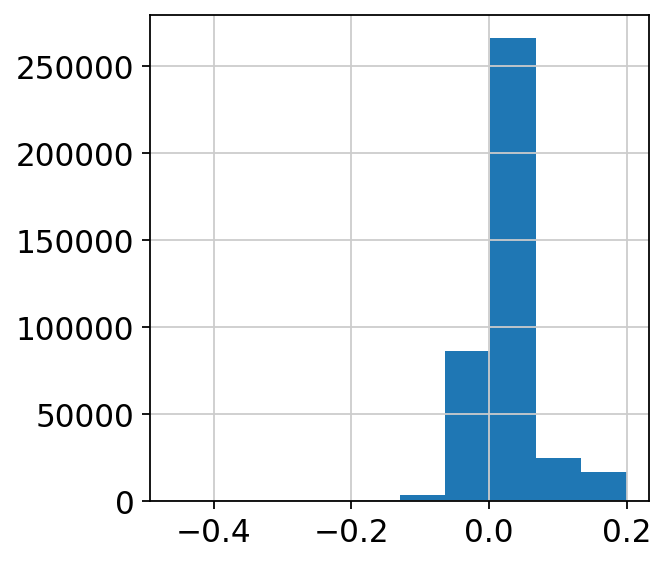

In [27]:
df_meta=df_meta_src.copy()
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=.2)
print(df_meta.shape)
#df_meta.to_csv('meta_samples_small.csv', index=False)
df_meta['singlecellprobability'].hist()

In [28]:
df_meta.tail(3)   


geo_accession                      title type                                characteristics_ch1 source_name_ch1     sample series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation  contact_name    contact_address contact_city contact_zip contact_country    contact_institute
722421     GSM999588  Parkinson's Disease PD 14  SRA  tissue: Human brain cortex (BA9),disease state...    Brain cortex  GSM999588  GSE40710    polyA RNA  RNA was extracted from frozen brain tissue usi...       2283349              cDNA  transcriptomic          RNA-Seq               0.009471     Sep 08 2012  Illumina reads were converted to FASTQ Sanger ...  Public on Oct 04 2012      May 15 2019             1  Homo sapiens      9606    GPL11154  Illumina HiSeq 2000  SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...  Herve,,RHINN  650 W. 168th. St.     New York                         USA  Columbia University
722422     GSM999589  Parkinson's Disease PD 15  SRA  tissue: Human brain cortex (BA9),disease state...    Brain cortex  GSM999589  GSE40710    polyA RNA  RNA was extracted from frozen brain tissue usi...       3253397              cDNA  transcriptomic          RNA-Seq               0.083552     Sep 08 2012  Illumina reads were converted to FASTQ Sanger ...  Public on Oct 04 2012      May 15 2019             1  Homo sapiens      9606    GPL11154  Illumina HiSeq 2000  SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...  Herve,,RHINN  650 W. 168th. St.     New York                         USA  Columbia University
722424     GSM999591  Parkinson's Disease PD 17  SRA  tissue: Human brain cortex (BA9),disease state...    Brain cortex  GSM999591  GSE40710    polyA RNA  RNA was extracted from frozen brain tissue usi...       1162666              cDNA  transcriptomic          RNA-Seq               0.019685     Sep 08 2012  Illumina reads were converted to FASTQ Sanger ...  Public on Oct 04 2012      May 15 2019             1  Homo sapiens      9606    GPL11154  Illumina HiSeq 2000  SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...  Herve,,RHINN  650 W. 168th. St.     New York                         USA  Columbia University

#### now all do a new filter

In [29]:
#### now all do a new filter
df_meta=df_meta_src.copy()
min_singlecellprobability=.5
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=min_singlecellprobability)
print(df_meta.shape)
# list of Strings to check for to include
#search_strings=['exitatory', 'Exitatory',  'glutamatergic', 'Glutamatergic']
search_strings_include=['dermatitis', 'Dermatitis']
df_meta=filter_df(df_meta, search_strings_include, include=True,ignore_columns=['data_processing'] )
print(df_meta.shape)
# list of Strings to check for to exclude
#search_strings_exclude=['GABAergic', 'gabaergic', 'GABA', 'gaba', 'inhibitory', 'Inhibitory']
#df=filter_df(df, search_strings_exclude, include=False,ignore_columns=None)
print(df_meta.shape)
#df.to_csv('meta_samples_small_dermatitis.csv', index=False)
df_meta.head(3)


(722425, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering to include ['dermatitis', 'Dermatitis']
(387, 30)
(387, 30)


geo_accession   title type                                characteristics_ch1        source_name_ch1      sample  series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation    contact_name               contact_address contact_city contact_zip contact_country                   contact_institute
275024    GSM3584918  AD pt1  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584918  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      18889411              cDNA  transcriptomic          RNA-Seq               0.076691     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis
275025    GSM3584919  AD pt2  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584919  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      19169479              cDNA  transcriptomic          RNA-Seq               0.043671     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis
275028    GSM3584922  AD pt3  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584922  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      23714976              cDNA  transcriptomic          RNA-Seq               0.020970     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis

### now load the gene expression data using the geo_accession column from the filtered meta data df 

### generate an adata object

In [30]:
filtered_metadata_df=df_meta.copy()
adata_src=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=False)
print(adata_src)
adata_src.obs.head(3)

AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx'
    var: 'ensembl_gene_id', 'biotype'


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


geo_accession   title type                                characteristics_ch1        source_name_ch1      sample  series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation    contact_name               contact_address contact_city contact_zip contact_country                   contact_institute  ARCHS4_idx
GSM3584918    GSM3584918  AD pt1  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584918  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      18889411              cDNA  transcriptomic          RNA-Seq               0.076691     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275024
GSM3584919    GSM3584919  AD pt2  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584919  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      19169479              cDNA  transcriptomic          RNA-Seq               0.043671     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275025
GSM3584922    GSM3584922  AD pt3  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584922  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      23714976              cDNA  transcriptomic          RNA-Seq               0.020970     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275028

In [31]:
adata.var.head(3)

ensembl_gene_id         biotype  highly_variable  highly_variable_rank     means  variances  variances_norm      mean       std
TSPAN6  ENSG00000000003  protein_coding            False                   NaN  2.828259   0.347677        1.153950  2.828259  0.589641
TNMD    ENSG00000000005  protein_coding            False                   NaN  1.045747   0.473683        0.958549  1.045747  0.688246
DPM1    ENSG00000000419  protein_coding            False                   NaN  3.629652   0.065343        0.215203  3.629652  0.255623

### generate an data frame object

In [32]:
filtered_metadata_df=df_meta.copy()
df_gex=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=True)
df_gex.head(3)

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


TSPAN6  TNMD  DPM1  SCYL3  C1orf112    FGR  CFH  FUCA2  GCLC  NFYA  STPG1  NIPAL3  LAS1L  ENPP4  SEMA3F  CFTR  ANKIB1  CYP51A1  KRIT1  RAD52  MYH16  BAD  LAP3  CD99  HS3ST1  AOC1  WNT16  HECW1  MAD1L1  LASP1  SNX11  TMEM176A   M6PR  KLHL13  CYP26B1  ICA1  DBNDD1  ALS2  CASP10  CFLAR  TFPI  NDUFAF7  RBM5  MTMR7  SLC7A2  ARF5  SARM1  POLDIP2  PLXND1   AK2  CD38  FKBP4  KDM1A   RBM6  CAMKK1  RECQL  VPS50  HSPB6  ARHGAP33  NDUFAB1  PDK4  SLC22A16  ZMYND10  ABCB5  ARX  SLC25A13  ST7  CDC27  SLC4A1  CALCR  HCCS  DVL2  PRSS22  UPF1  SKAP2  SLC25A5  MCUB  HOXA11  POLR2J  DHX33  MEOX1  THSD7A  LIG3  RPAP3  ACSM3  REXO5  CIAPIN1  SPPL2B  FAM214B  COPZ2  PRKAR2B  MSL3  CREBBP  TSPOAP1  MPO  PON1  GCFC2  WDR54  CROT  ABCB4  KMT2E  RHBDD2  SOX8  IBTK  ZNF195  MYCBP2  FBXL3  ITGAL  PDK2  ITGA3   ZFX  LAMP2  ITGA2B  ASB4  GDE1  REX1BD  CRLF1  OSBPL7  TMEM98  YBX2  KRT33A  MAP3K14  ABCC8  CACNG3  TMEM132A  AP2B1  TAC1  ZNF263  CX3CL1  SPATA20  CACNA1G  TNFRSF12A  DLX6  MAP3K9  RALA  \
geo_accession                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
GSM3584918         65     0  1064    696        99   3858  114     84   363   246    156    1916   1315    368       5     5    1835      844    993    541      2   30  2528  2621       9     9      1     28      62   1394    528         9   5497       3        2    87       4   800     889   4079   230      504  6206     34       6   288    203      917      65   907  2025    146    768  18804      39   1561    249      1        16      614    25         2       16     44    2       268  533    610      39      2   141    70       0    89   1718     7090   151       0     481    515      0       2   644    756     94     22     1918      42      158     28        4  1808    1079      265    3     7    179    984   233      6   8743     484    13   375     954    2580    653  10613   113     76  2960   1912      35    27  1376     256     11     187      20     1       0       86     46       0        32    418     0     126      37       53       24          0     7     129   102   
GSM3584919         53     0   660   1049       253  16327  130    106   403   436    158    4140   1464    955      12     5    1900     1158   1164   2144      3   45  1790  2289      13     6     25     20      95   2357    865         5   9836      25       12   139       6   828    2450   4476   271      413  8465     13      13   344    168      617     136  1033  4338    156    697  55714      42   2659    326      1        13      360     8         2       48     30    5       278  678    491      32      1   137    86       1    81   2783     9155    71       5     320    671      4       5   800    884    105     17     2307      47      411      7       11  1676    1279      214    4    10    204    766   277     26   6468     448    14   361     952    2311    265  13308   165     61  8084   1801      49    15  1305     547     23     119      22     3       0      139     64       1        34    620     0     145      41       64       28          1     7      84   151   
GSM3584922         

### save processed data

# Analysis ends here